
    Script to run ribosome analysis
    Copyright (C) 2019  Fuad Mohammad, fuadm424@gmail.com


    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.
    



# Density analysis script

This notebook will use density files made from the FASTQ processing script and analyze features relevant to translation. This can also be applied to RNA-seq to investigate RNA coverage over the CDS:

   - 

   - Average gene plot condenses ribosome footprints aligned to the start and stop codons of every gene. 
       - Initiation and termination 
       - periodicity
       - occupancy on CDS and UTR
   - Frame analysis condenses reads into the three reading frames, informing on the occupancy at each frame. ribosome footprints should show strong 3nt periodicity. 
       - Frame analyzed using all density sizes, size separated densities, or gene separated 
   - Assymetry analysis informs on the degree of dropoff/runoff in the data. 
   - Pause score analysis provides relative occupancy information on different codons/amino acids. 

# General Settings:

Directory Data:

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from datetime import datetime


import ribo_util
import ribo_main
import ribo_analysis
import ribo_plot


organism = 'Coli'      #Coli, Subtilis, Tuberculosis, Salmonella etc...

inputs = {}
inputs['files'] = []
inputs['multiprocess'] = 'yes'
inputs['threads']      = 8   # CPU information for multithreading applications
inputs['cores']        = 4

path_pc     = '/Volumes/HDD/Ribo_seq/'
inpath      = path_pc + 'libraries/'
path_script = '/Users/fuad/Dropbox/'

paths_in = {}
paths_in['path_gff_dict'] = path_pc + 'annotations/'+organism+'/'+organism+'_dict'   #will be made from GFF

paths_out = {}
paths_out['path_density']      = inpath  + 'density/density/'
paths_out['path_log']          = inpath  + 'density/logs/'
paths_out['path_analysis_log'] = inpath  + 'analysis/logs/'
paths_out['path_analysis']     = inpath  + 'analysis/individual/'
paths_out['path_figures']      = inpath  + 'figures/'

'''can place files in .csv with header == Library, or input file names into list  '''
all_files  = []
file_csv   = path_pc  + 'Methods_paper/all_libraries.csv' #path_pc  + 'Methods_paper/all_libraries.csv'
library_id = pd.read_csv(file_csv)

for fname in library_id.Library:
    '''if not 'CW60' in all_files:
        if not fname == 'CW60':
            continue
        else:
            all_files.append(fname)
            
    else: '''
    all_files.append(fname)
print all_files
    
# Check inputs, create output paths
step = 'density'
ribo_util.check_inputs(inputs, paths_in, step)
ribo_util.createpath(inputs, paths_out)


['CW63', 'OL38', 'OL34', 'OL35', 'OL18', 'OL19', 'OL20', 'OL21', 'OL1', 'OL2', 'OL24', 'OL25', 'OL26', 'OL27', 'OL28', 'OL29', 'OL30', 'OL12', 'OL13', 'OL14', 'OL36', 'OL10', 'OL11', 'OL16', 'OL17', 'CW60', 'FM24', 'FM85', 'FM22', 'FM88', 'FM40', 'FM20', 'FM67', 'FM91', 'FM86', 'FM87', 'FM89', 'FM90', 'FM92', 'FM93']


# Analysis Settings

Set settings values for the various analyses

In [3]:
# General Settings 
settings = {}
settings['minlength'] = 23
settings['maxlength'] = 40
settings['shift']     = 11
settings['gff_extra'] = 50
settings['threshold'] = 1     # in reads per codon
settings['alignment'] = '3'   # '3' or '5'
# Avggenes Settings
settings['length_out_ORF'] = 50
settings['length_in_ORF']  = 100        # genes shorter than this are excluded
settings['density_type']   = 'reads'    # 'reads' or 'rpm' 
settings['equal_weight']   = 'yes'      # 'yes' or 'no', if yes, change density_type to reads -- faster
settings['next_gene']      = 25         # genes closer than this are removed from start and stop 
settings['threshold']      = 50       # RPKM, genes below will be removed from average

# For asymmetry plot
settings['subgroup'] = '/Volumes/HDD/Ribo_seq/annotations/Coli/SRP_IP.csv'    #provide list of genes or 'none'

# Pausescore settings
settings['A_site shift']    = -11
settings['plot_upstream']   = 40
settings['plot_downstream'] = 50
settings['start_trim']      = 50
settings['stop_trim']       = 20
settings['frameshift']      = 0

# Genelist settings


# Pausescore waves settings
settings['plot_upstream_wave']   = 0
settings['plot_downstream_wave'] = 106
settings['next_codon']           = 'yes'

# Motif analysis
settings['motif_length'] = 9


In [3]:
lib_count = len(all_files)
lib_index = 0 
lib_runs  = 8  # limits number of samples processed, scale with RAM imitations

for loops in range(0, lib_count / lib_runs + 2):

    if lib_index < lib_count:
        print "Started  at " + str(datetime.now())
        if lib_count - lib_index >= lib_runs:
            inputs['files'] = [all_files[i] for i in range(lib_index, lib_index + lib_runs)]

            print inputs['files']
            
            if not 'gff_dict' in globals(): 
                gff_dict, plus_dict, minus_dict = ribo_util.loadlargePickles(inputs, settings, paths_in, paths_out)
            else: 
                gff_dict, plus_dict, minus_dict = ribo_util.loadlargePickles(inputs, settings, paths_in, paths_out)
            
            average_gene = ribo_analysis.avggenes(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            pausescore_analysis = ribo_analysis.pausescore(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            genelists = ribo_analysis.genelist(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            asymmetry_analysis = ribo_analysis.asymmetry(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            frame_analysis     = ribo_analysis.frame(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            wave_analysis = ribo_analysis.pausescore_waves(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            motif_analysis = ribo_analysis.motif_pausescore(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            
        else:
            inputs['files'] = [all_files[i] for i in range(lib_index, lib_count)]
            
            print inputs['files']    
            if not 'gff_dict' in globals(): 
                gff_dict, plus_dict, minus_dict = ribo_util.loadlargePickles(inputs, settings, paths_in, paths_out)
            else: 
                gff_dict, plus_dict, minus_dict = ribo_util.loadlargePickles(inputs, settings, paths_in, paths_out)
                
            average_gene = ribo_analysis.avggenes(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            pausescore_analysis = ribo_analysis.pausescore(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            genelists = ribo_analysis.genelist(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            asymmetry_analysis = ribo_analysis.asymmetry(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            frame_analysis     = ribo_analysis.frame(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            wave_analysis = ribo_analysis.pausescore_waves(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            motif_analysis = ribo_analysis.motif_pausescore(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)

    else:
        continue
    lib_index += lib_runs  
print "Finished  at " + str(datetime.now())

Started  at 2018-08-31 16:13:01.804978
['CW63', 'OL38', 'OL34', 'OL35', 'OL18', 'OL19', 'OL20', 'OL21']
Started avggenes at 2018-08-31 16:21:15.686000
	For OL18: 1062 out of 4425 genes in average.
	    - genes failing distance cutoff = 1645
	    - genes failing length cutoff   = 31
	    - genes failing RPM cutoff      = 1444
	    - genes in blacklist            = 243
	For OL35: 824 out of 4425 genes in average.
	    - genes failing distance cutoff = 1645
	    - genes failing length cutoff   = 31
	    - genes failing RPM cutoff      = 1682
	    - genes in blacklist            = 243
	For OL34: 865 out of 4425 genes in average.
	    - genes failing distance cutoff = 1646
	    - genes failing length cutoff   = 31
	    - genes failing RPM cutoff      = 1640
	    - genes in blacklist            = 243
	For OL21: 1086 out of 4425 genes in average.
	    - genes failing distance cutoff = 1645
	    - genes failing length cutoff   = 31
	    - genes failing RPM cutoff      = 1420
	For CW63: 1018 ou

ribo_analysis.py:1273: RuntimeWarning:

divide by zero encountered in log2



Finished asymmetry analysis at 2018-08-31 16:30:46.784392
Started frame analysis at 2018-08-31 16:30:46.784621
Finished frame analysis at 2018-08-31 16:30:57.376627
Started pause score analysis at 2018-08-31 16:30:57.377484
472
3134
70
749
472
3135
70
748
472
3061
70
822
472
2946
70
937
472
2243
70
1640
472
2083
70
1800
472
1888
70
1995
472
1636
70
2247
Finished pause score analysis at 2018-08-31 16:35:48.914110
Started pause score analysis at 2018-08-31 16:35:48.914620
354
1675
74
2322
354
1935
74
2062
354
2299
74
1698
354
2135
74
1862
354
3211
74
786
354
3210
74
787
354
3014
74
983
354
3129
74
868
Finished pause score analysis at 2018-08-31 18:51:21.066632
Started  at 2018-08-31 18:51:21.076539
['OL1', 'OL2', 'OL24', 'OL25', 'OL26', 'OL27', 'OL28', 'OL29']
Started avggenes at 2018-08-31 18:59:56.246563
	For OL28: 925 out of 4425 genes in average.
	For OL29: 918 out of 4425 genes in average.
	    - genes failing distance cutoff = 1646
	    - genes failing distance cutoff = 1646
	    -

In [4]:
#for fname in all_files:
    #inputs['files'] = [fname]
    #gff_dict, plus_dict, minus_dict = ribo_util.loadlargePickles(inputs, paths_in, paths_out)

    #motif_analysis = ribo_analysis.motif_pausescore(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)

# --------------------------------------------------------------------------


# Gene Average Analysis:

Calculate average ribosome occupancy aligned at start or stop codons, as well the symmetry of ribosome distribution on genes and the periodicity associated with the density

Settings for asymmetry analysis:

In [32]:
inputs['files'] = all_files

settings_plot = {}
settings_plot['HM_max'] = 2
settings_plot['shift']  = 15
settings_plot['ymax']   = 5

#average_plot = ribo_plot.plot_avggene(inputs, paths_in, paths_out, settings, settings_plot)

# Frame Analysis

Calculate reading frame of all footprints, as well as for each readlength and each gene:

   - RPKM threshold used above still applies. To change, redefine below 

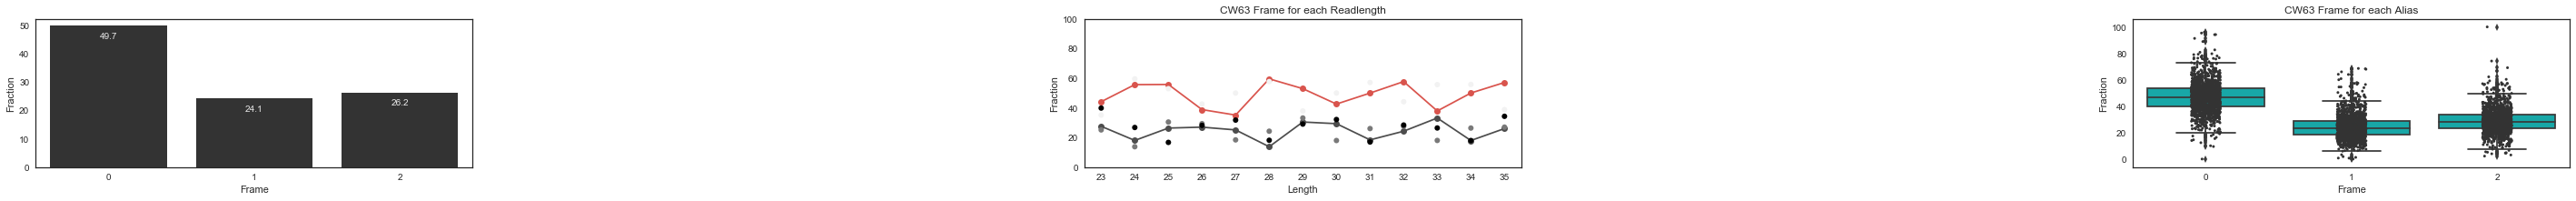

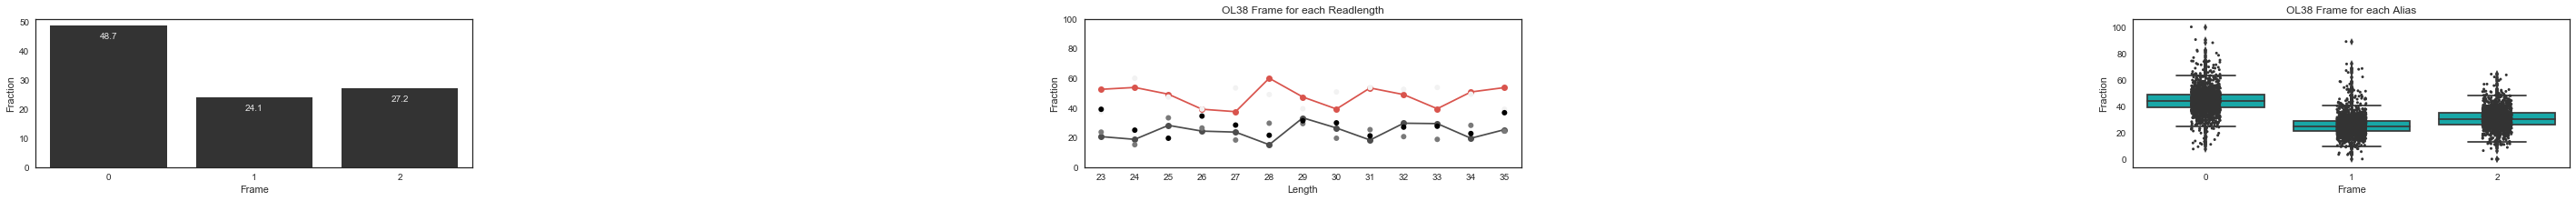

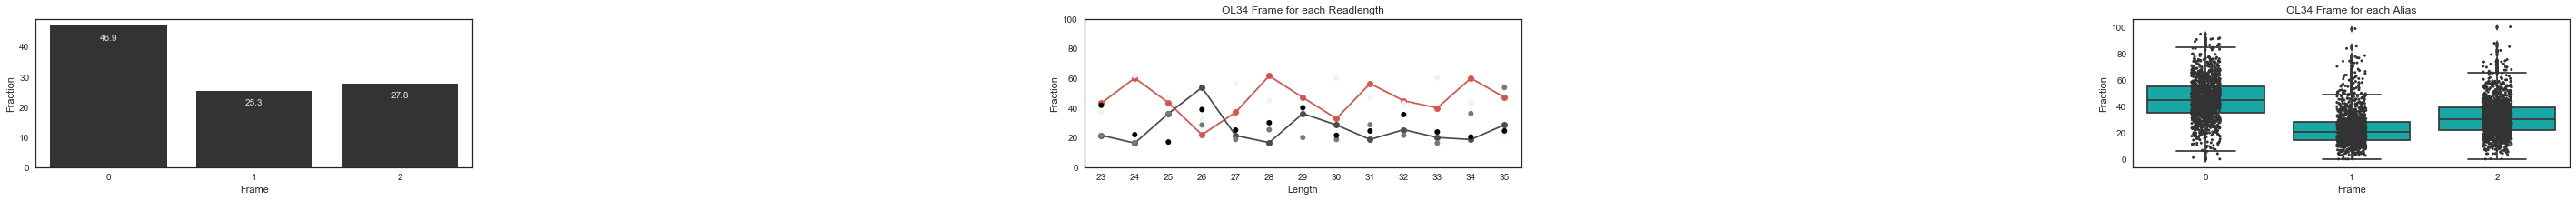

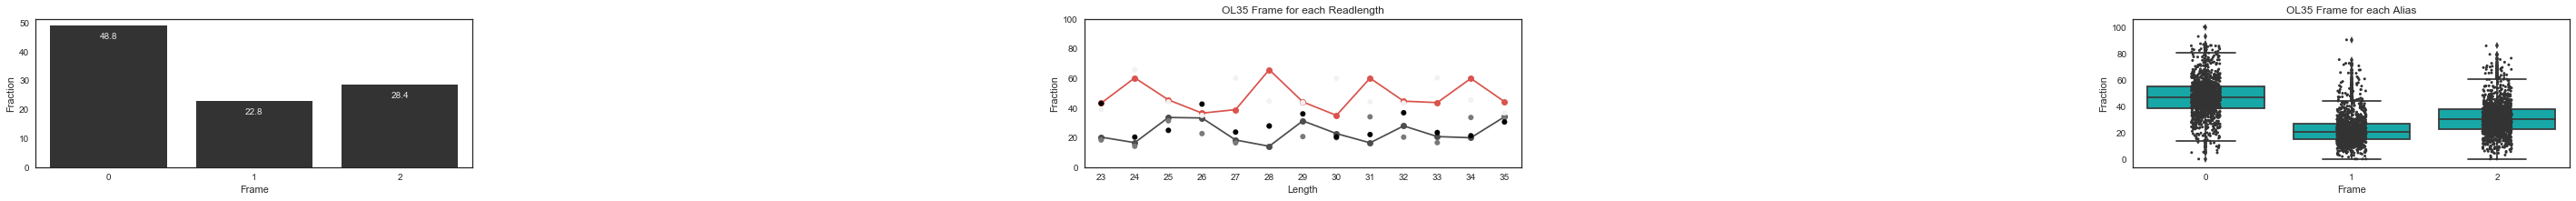

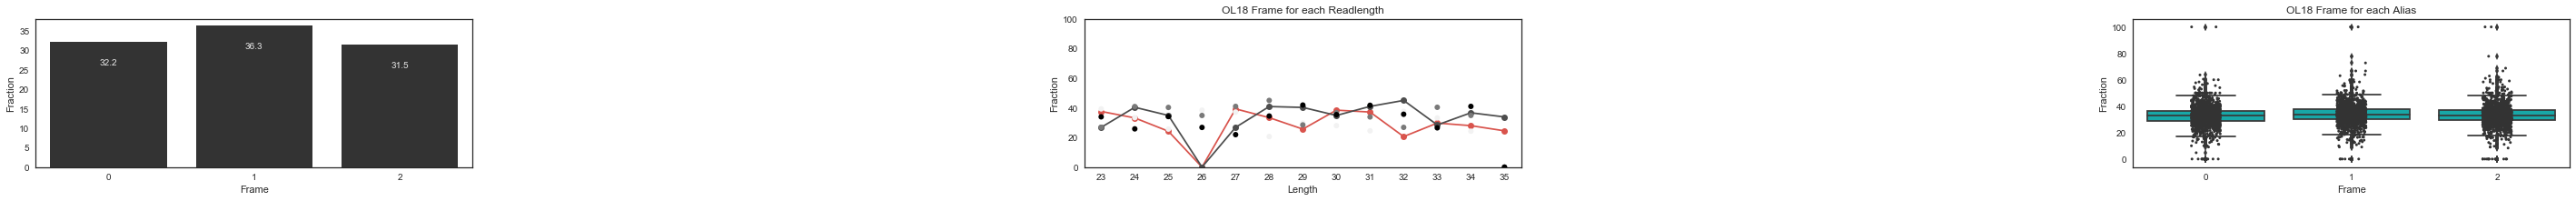

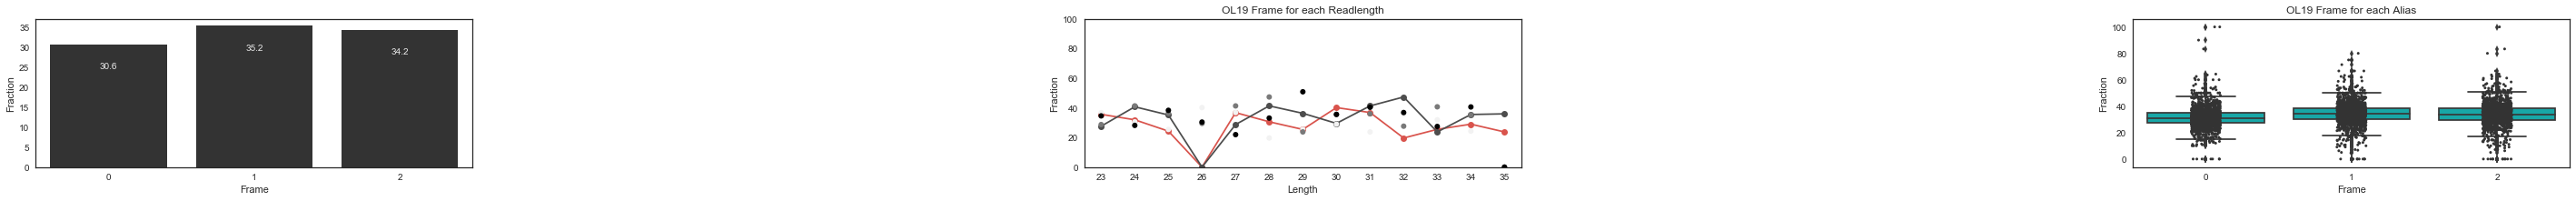

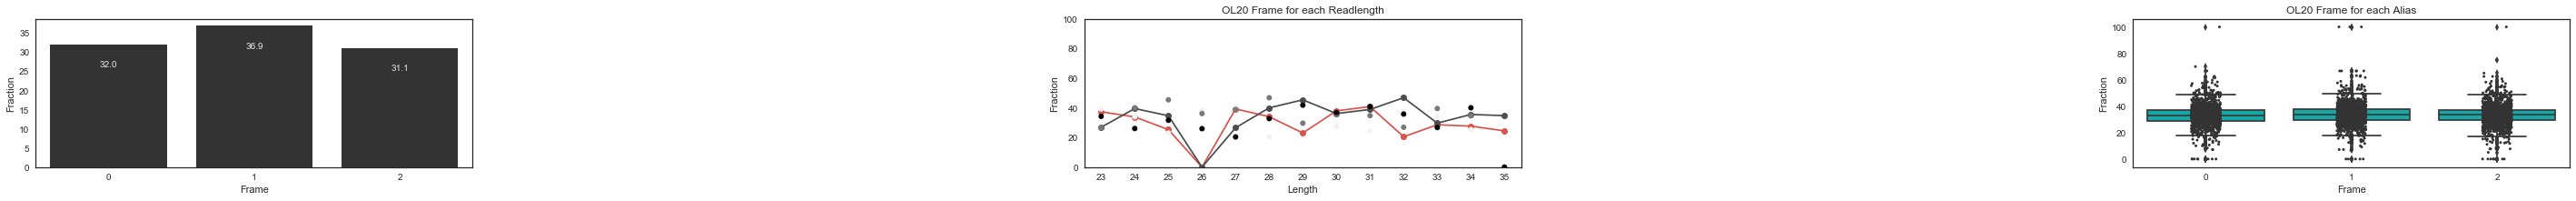

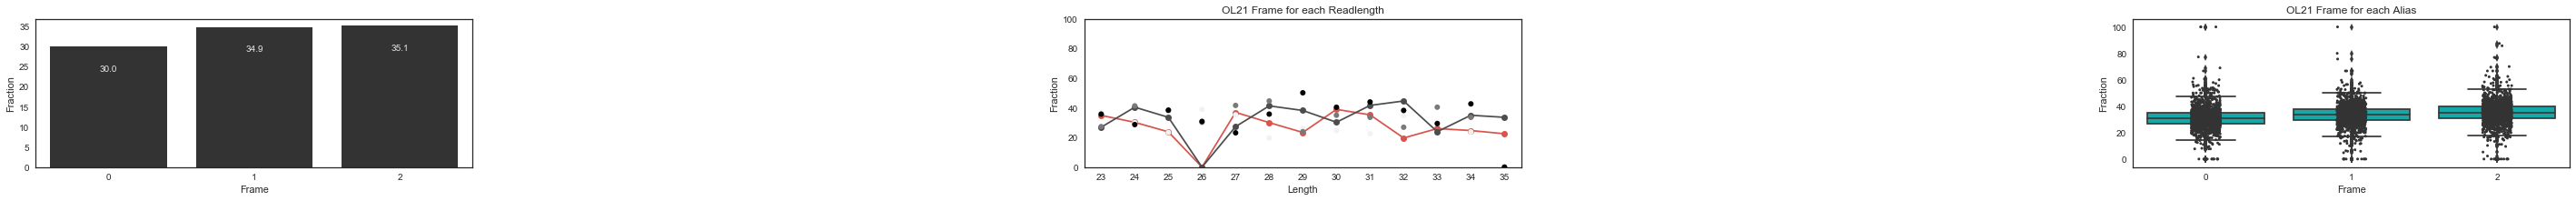

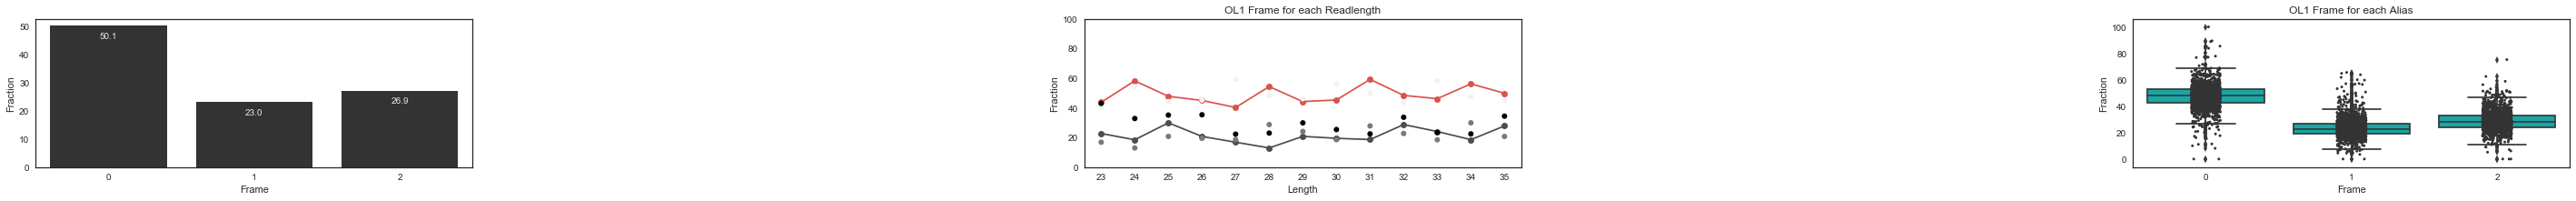

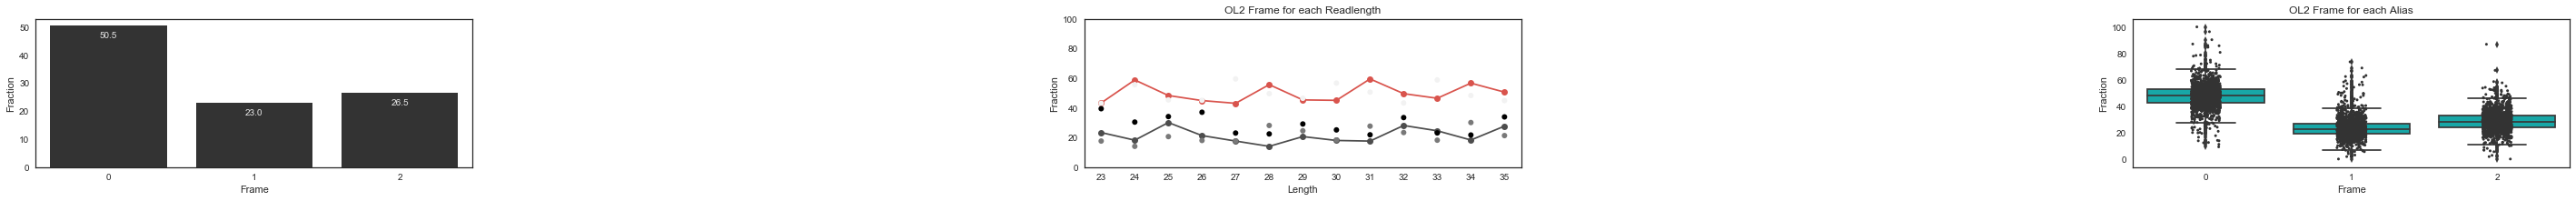

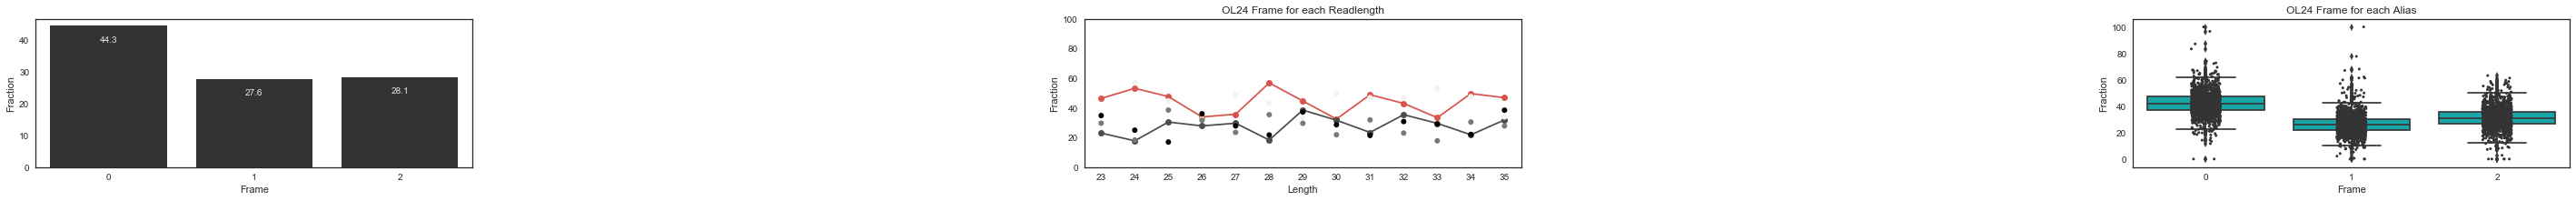

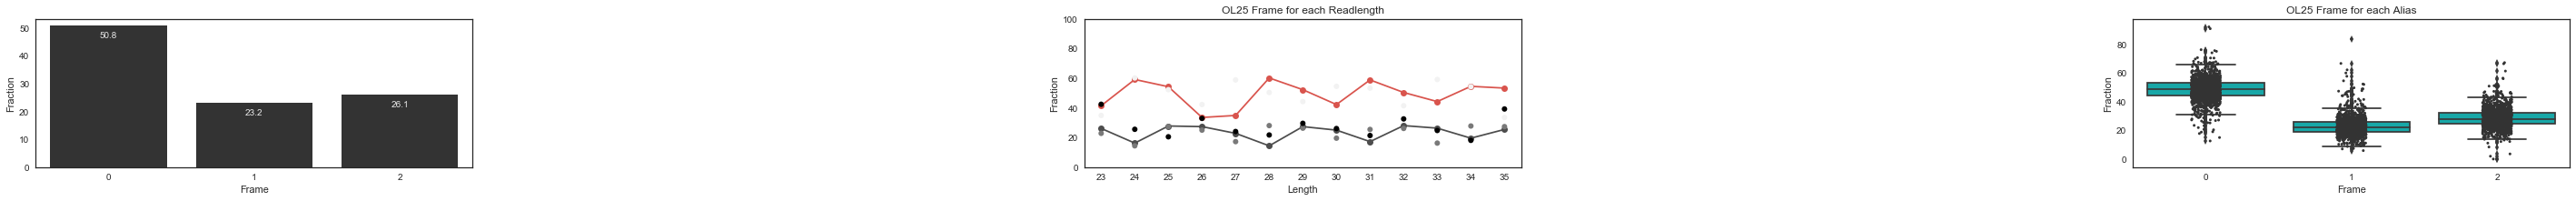

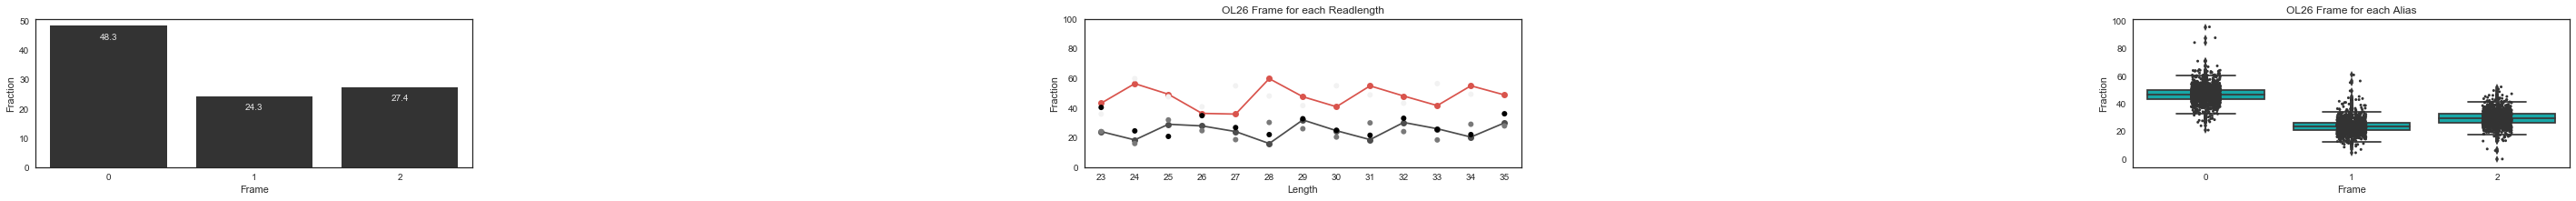

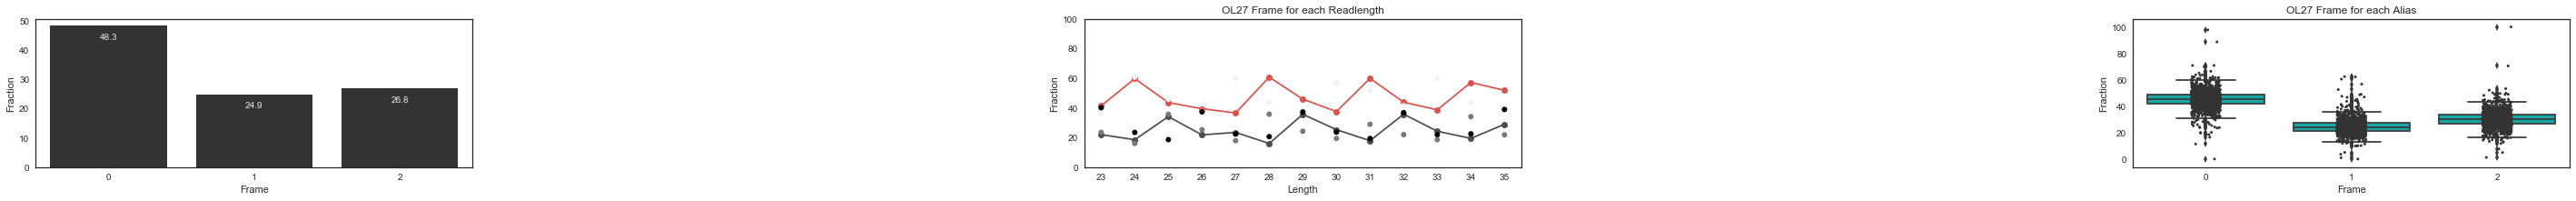

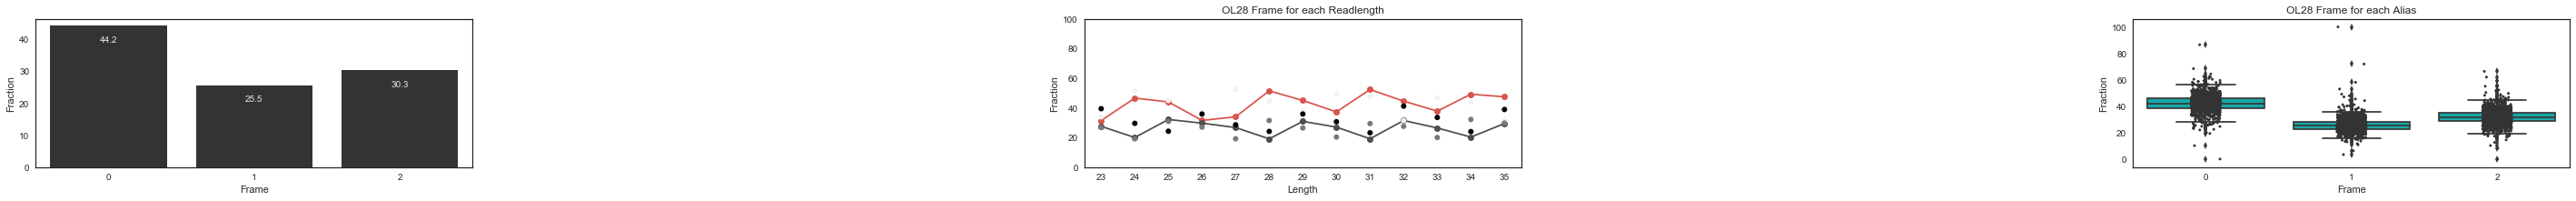

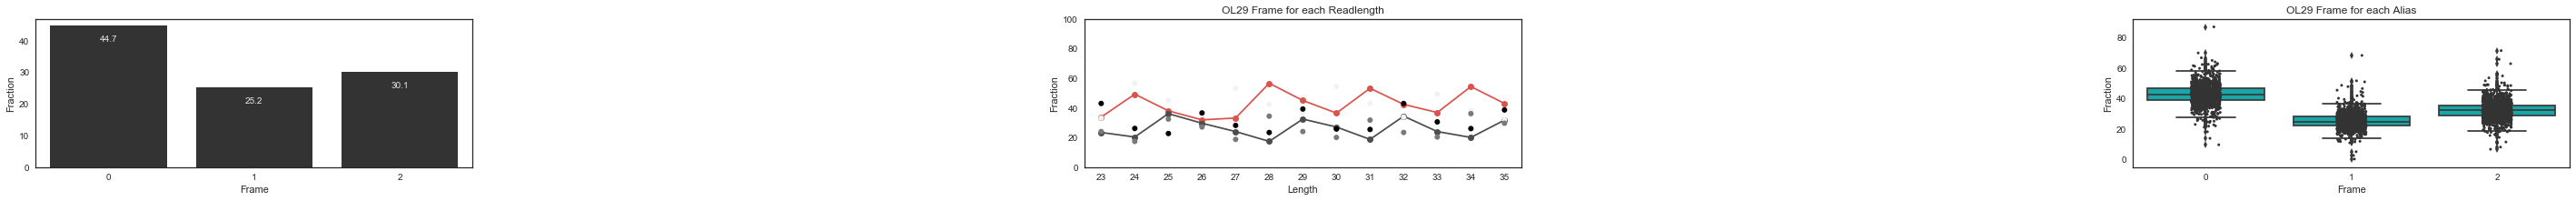

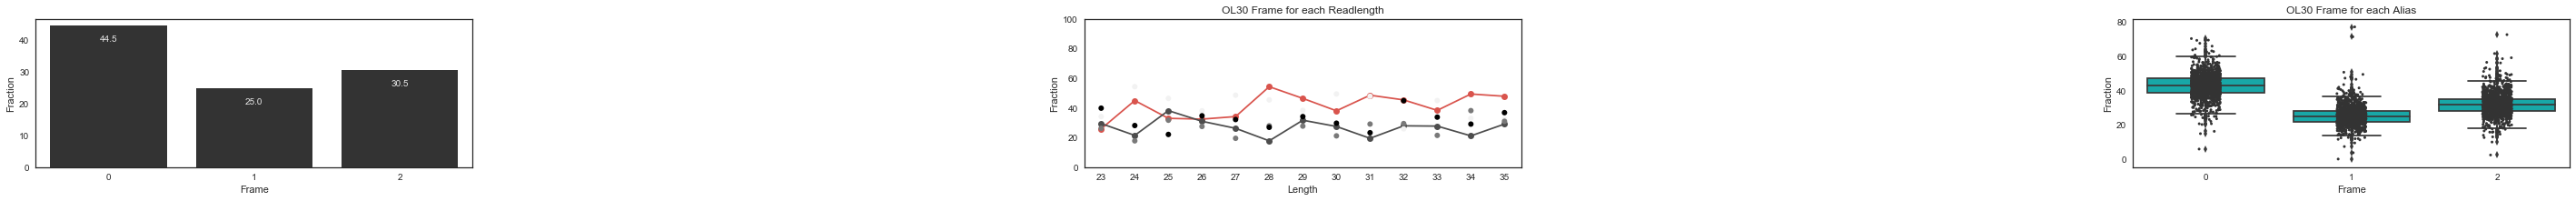

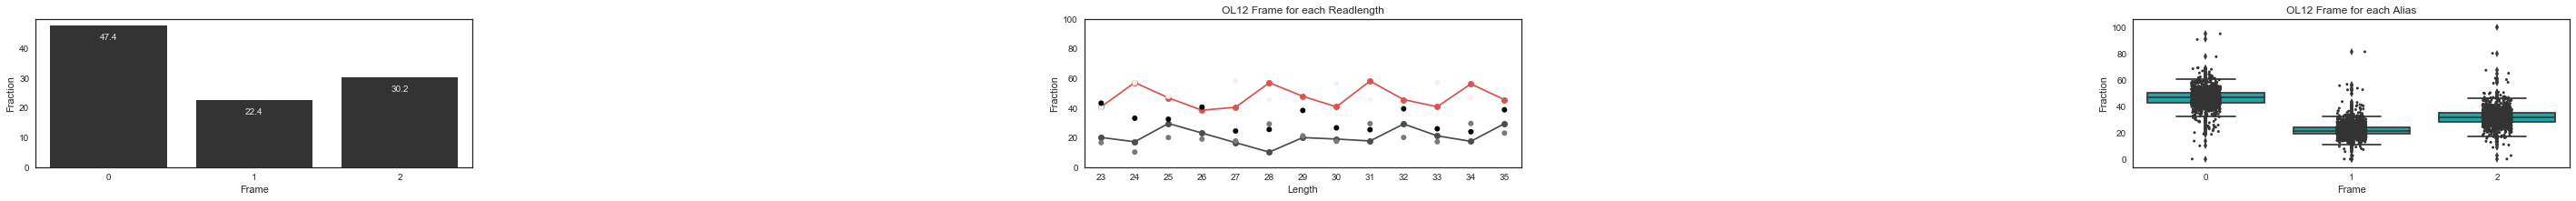

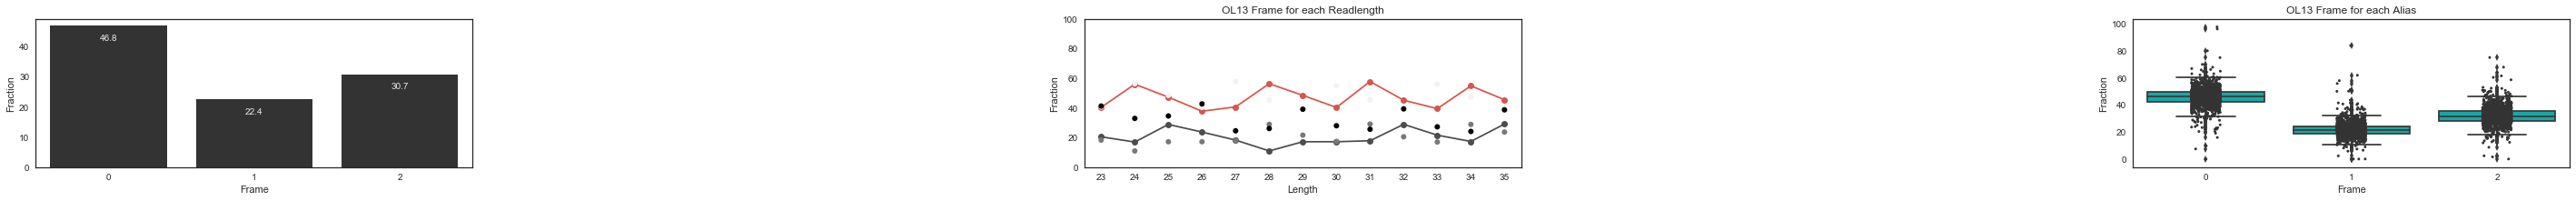

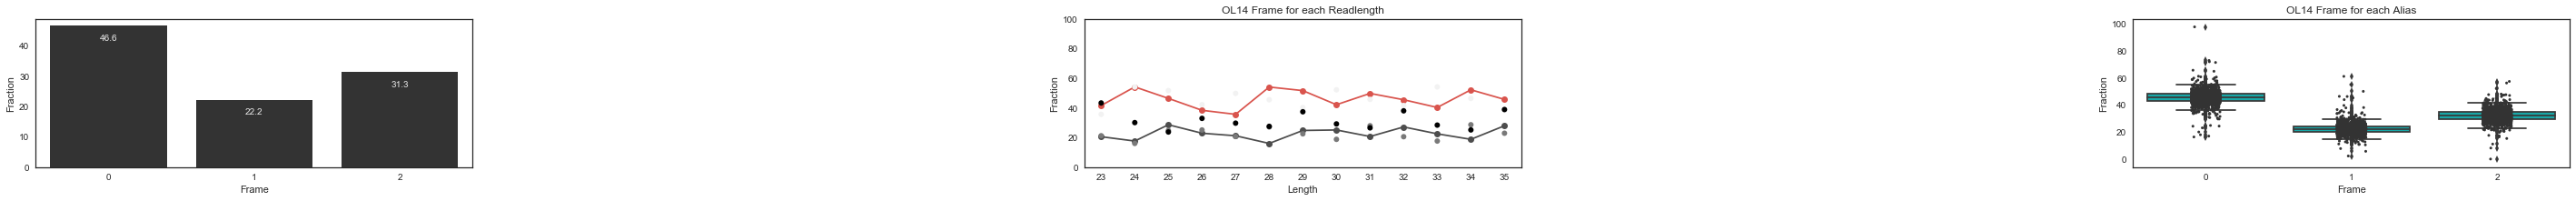

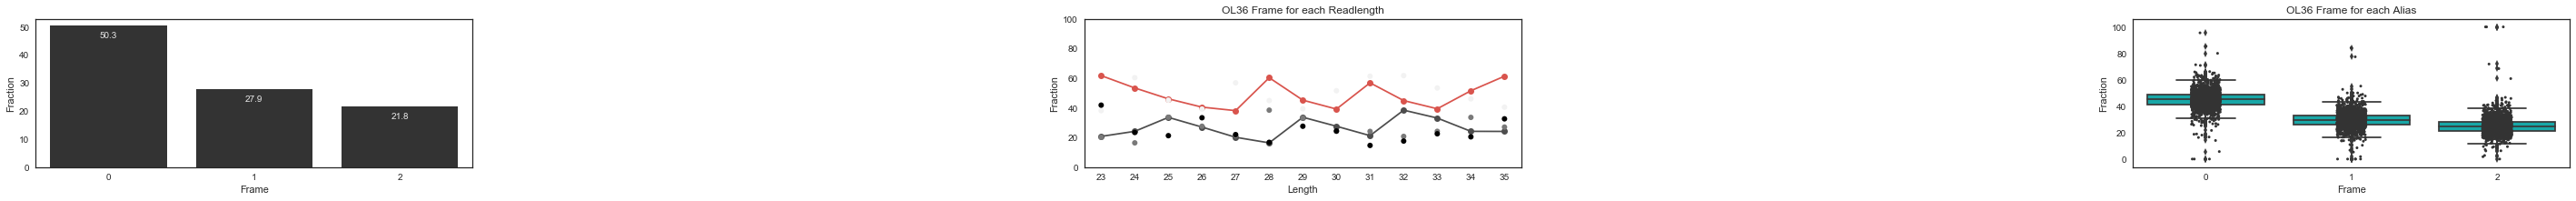

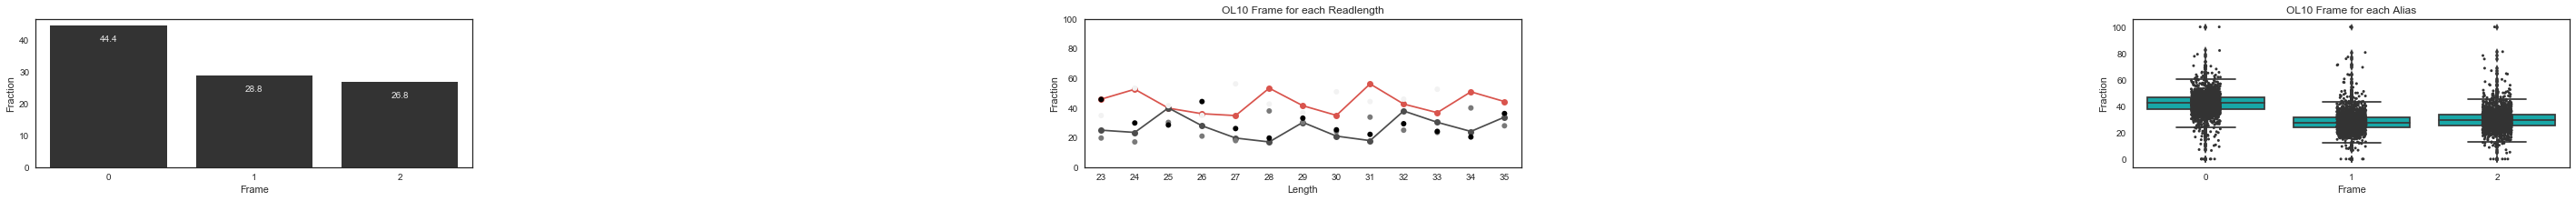

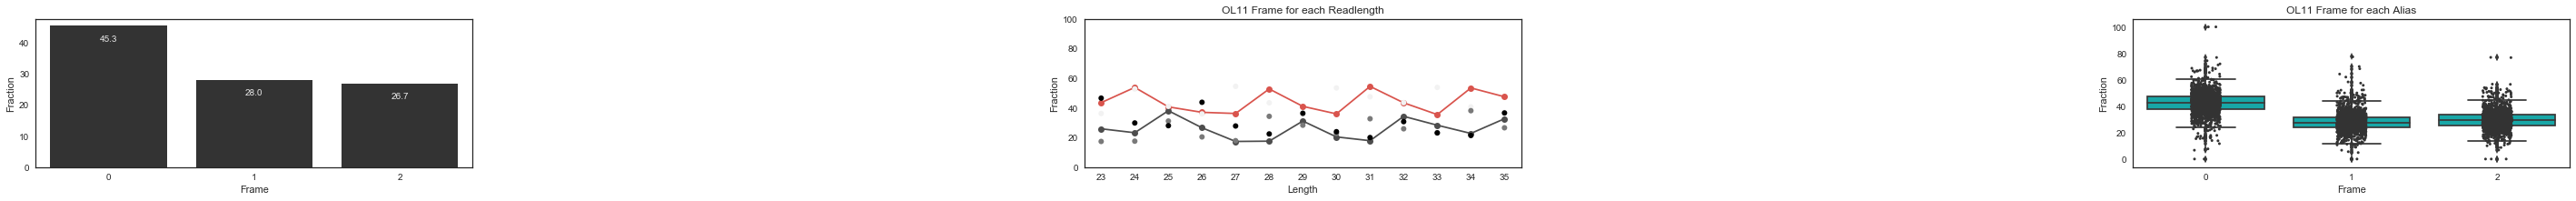

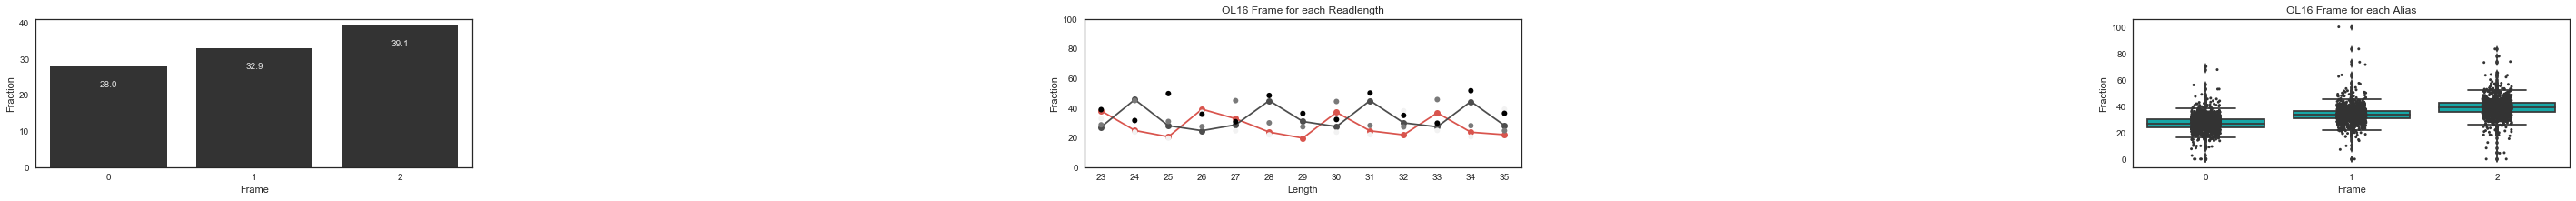

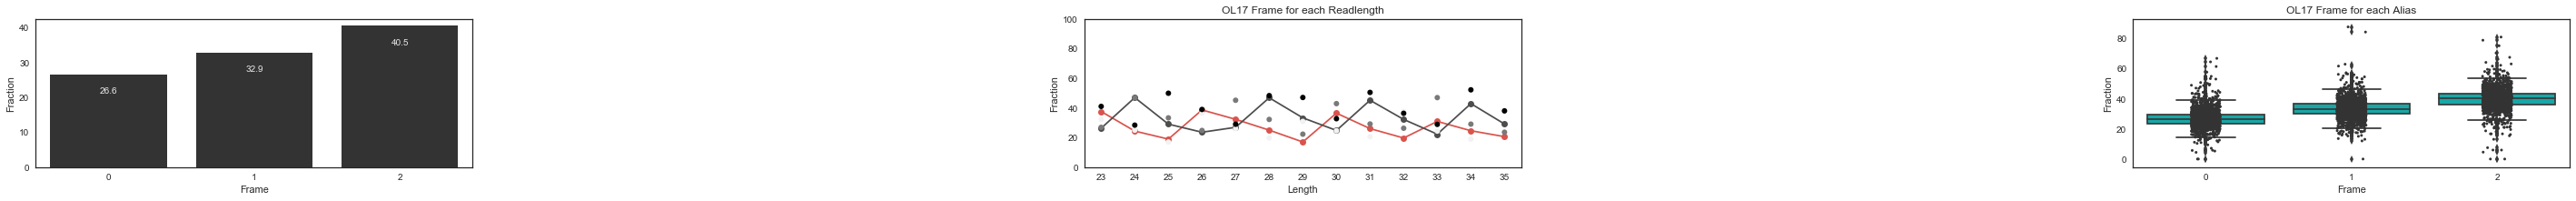

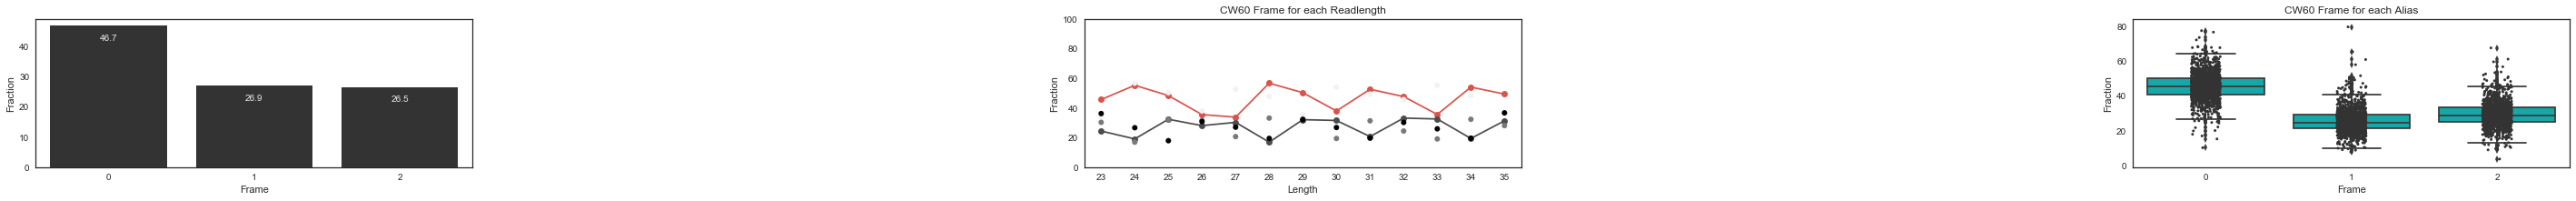

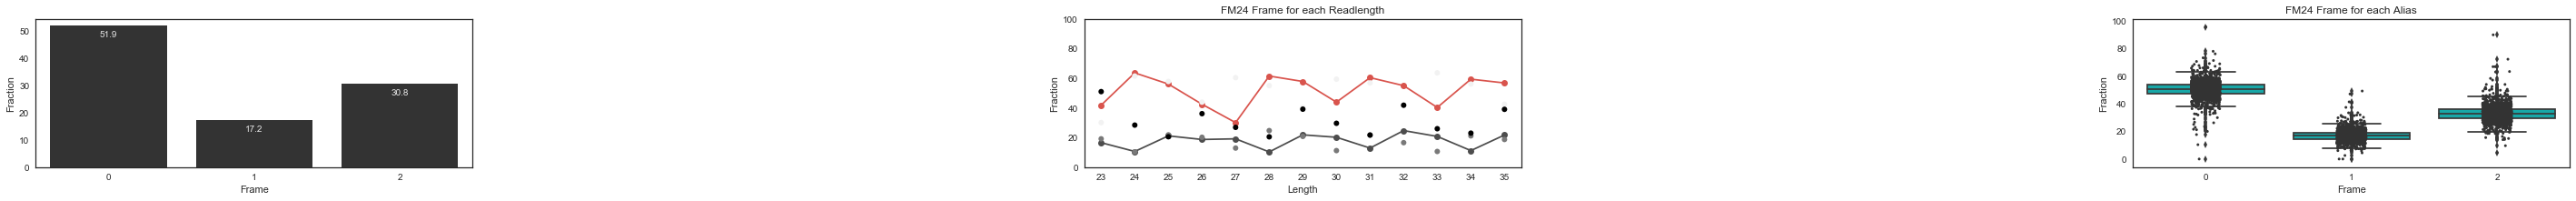

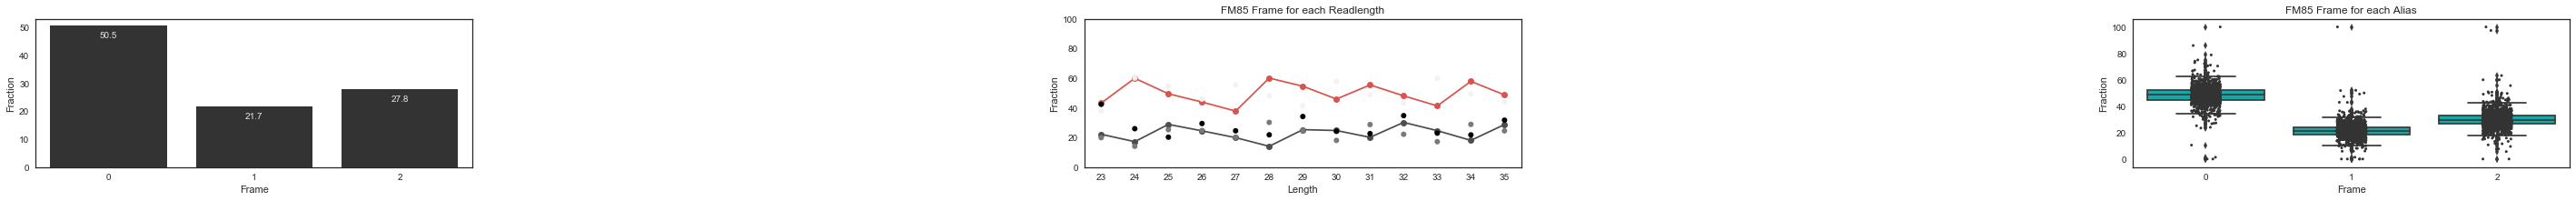

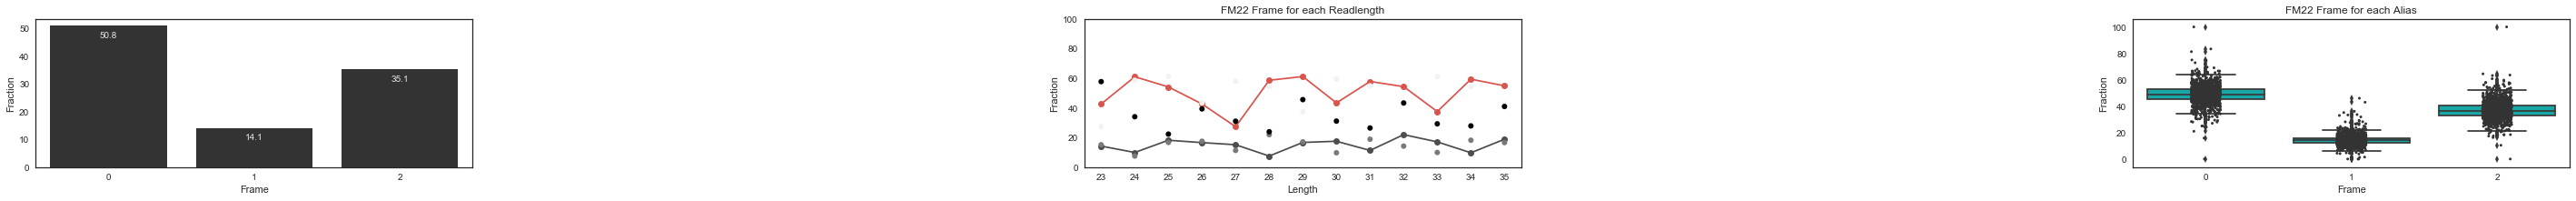

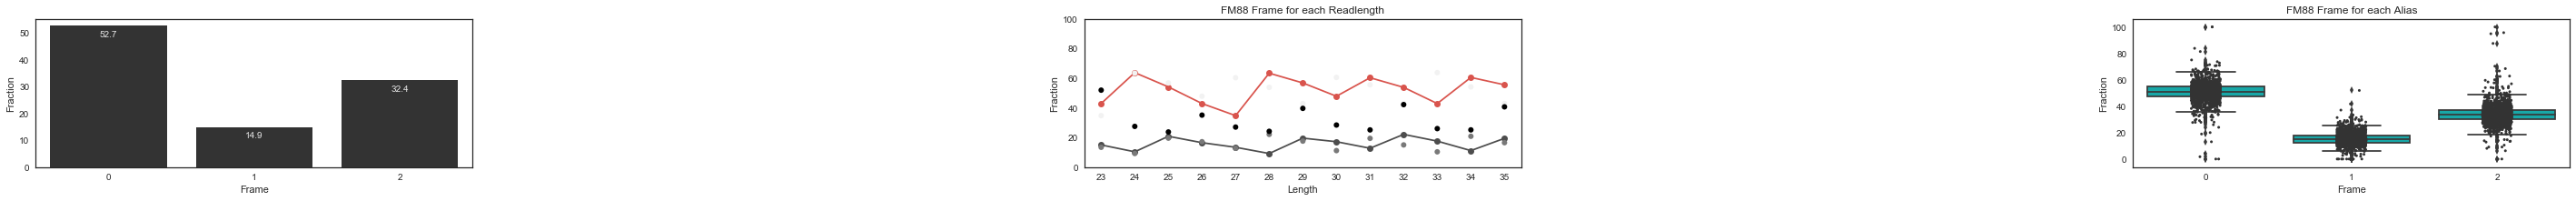

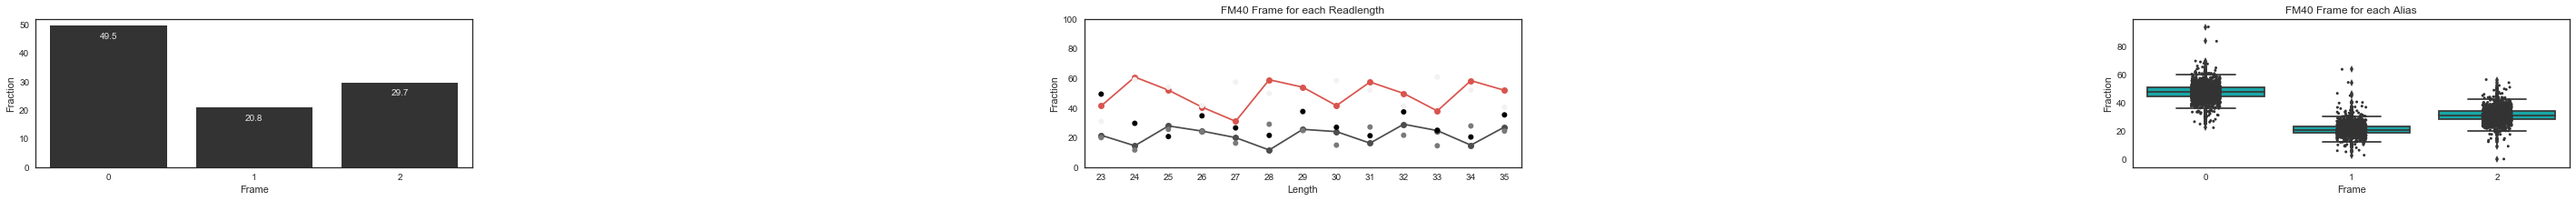

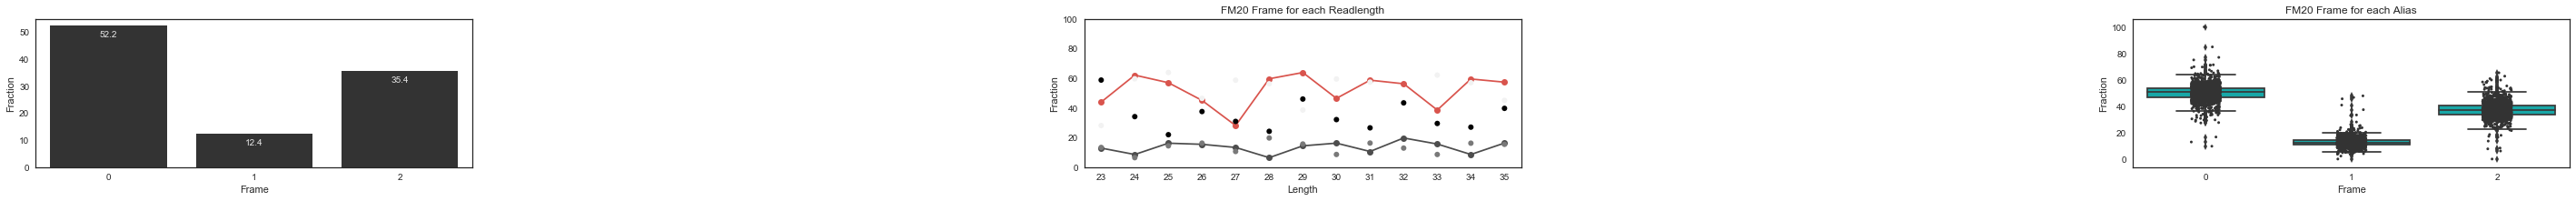

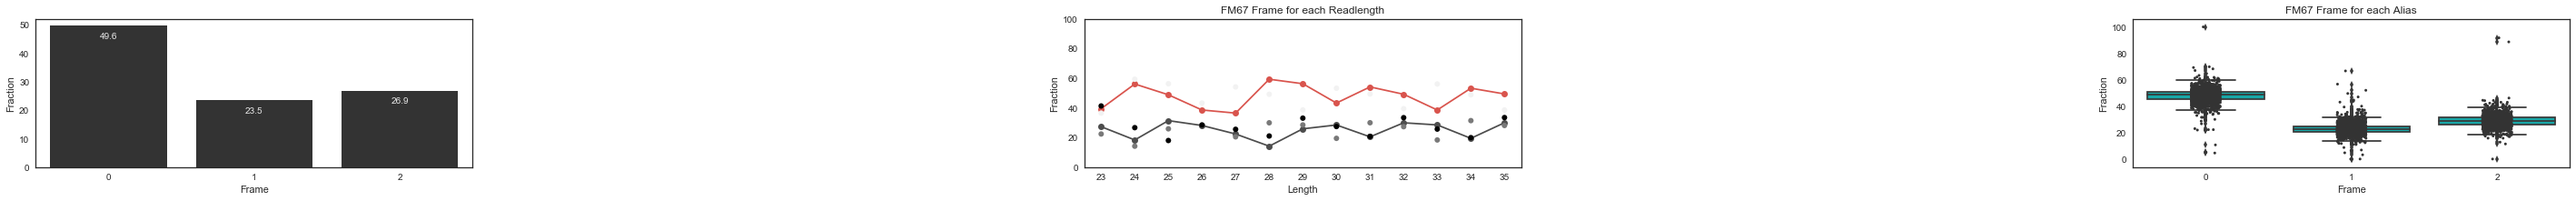

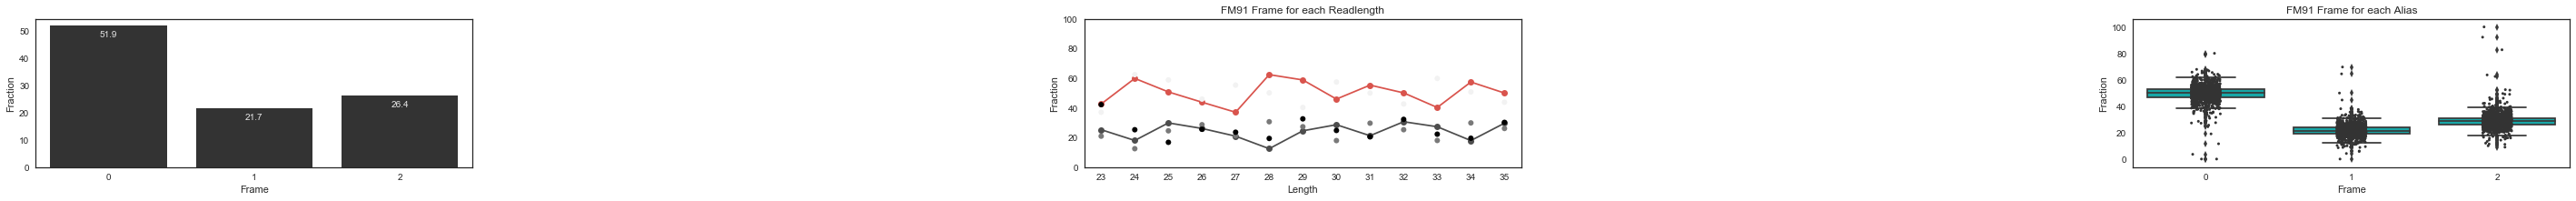

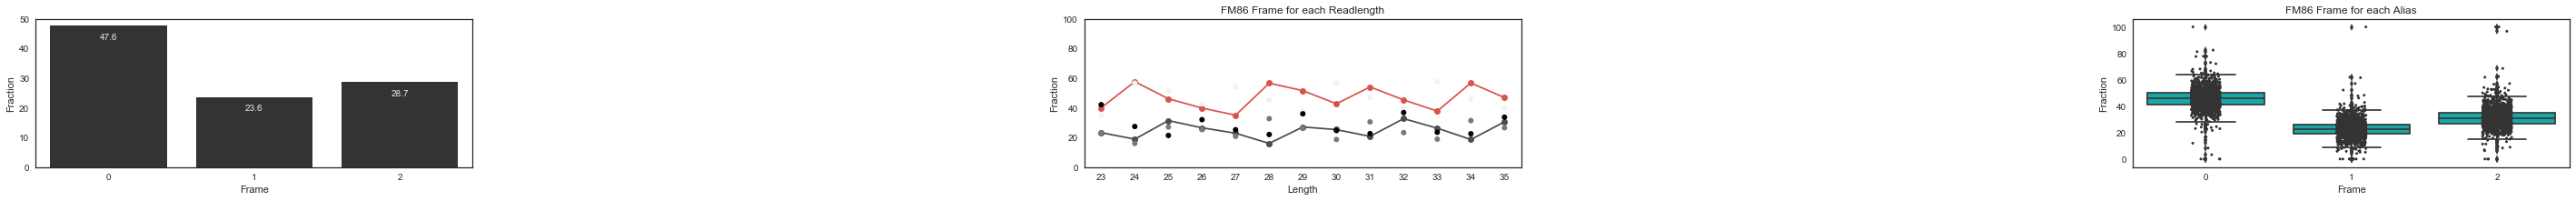

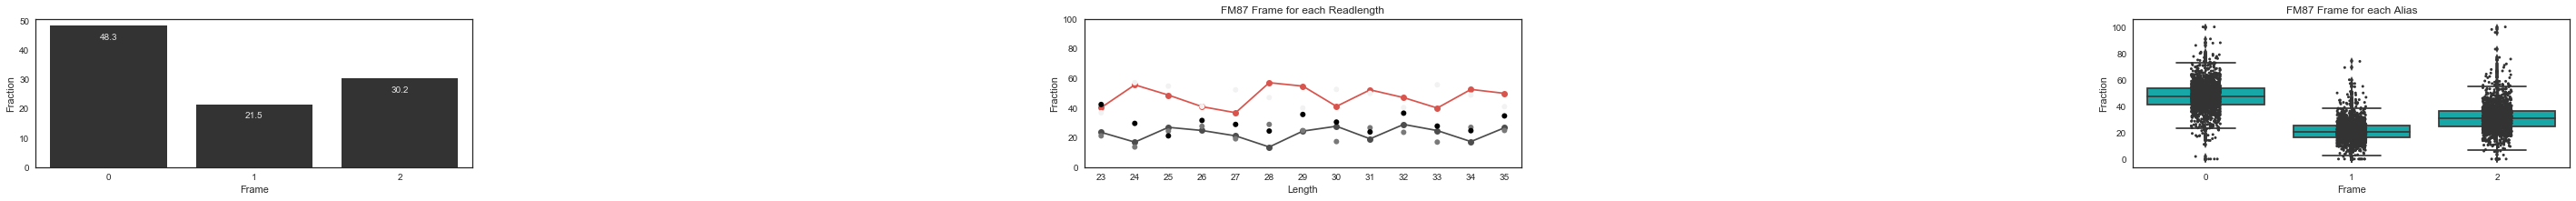

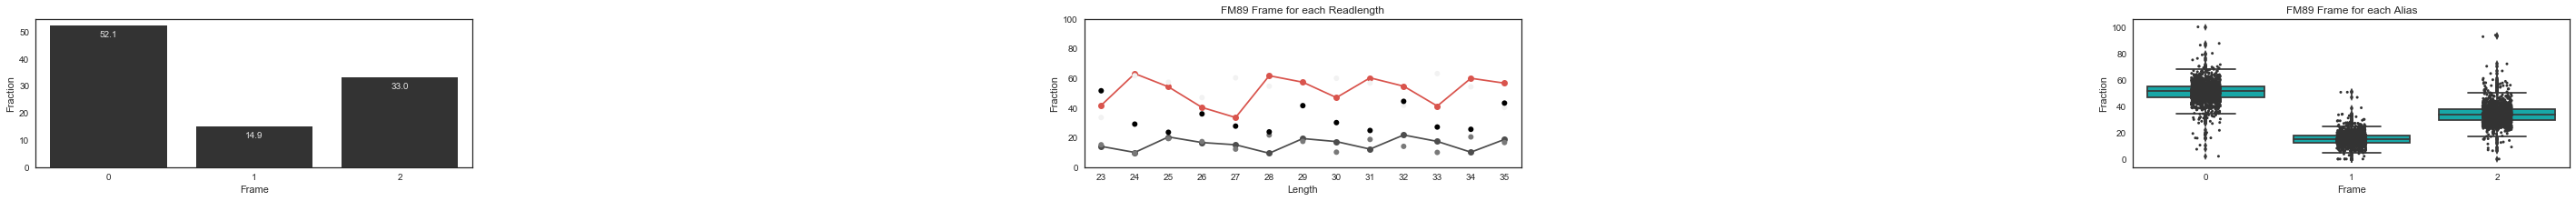

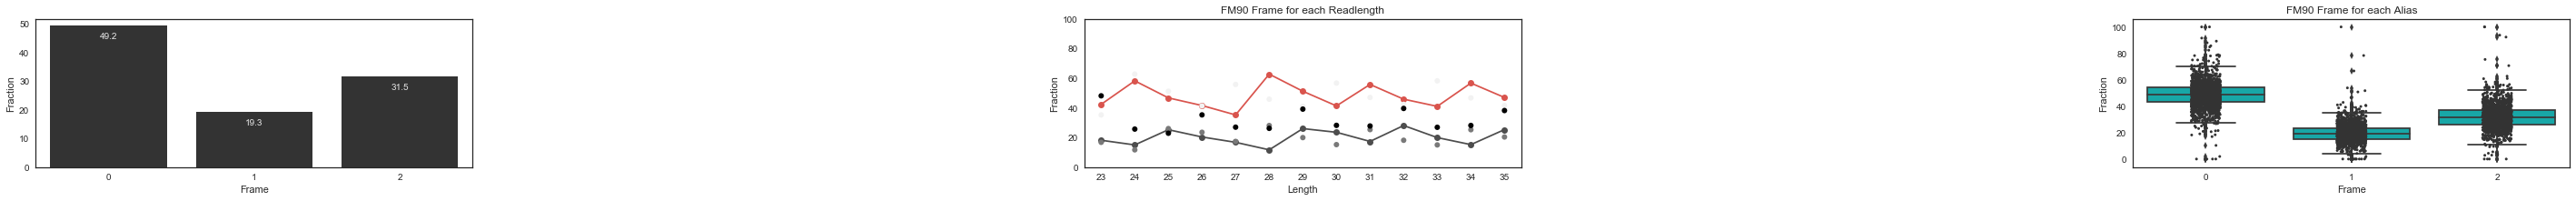

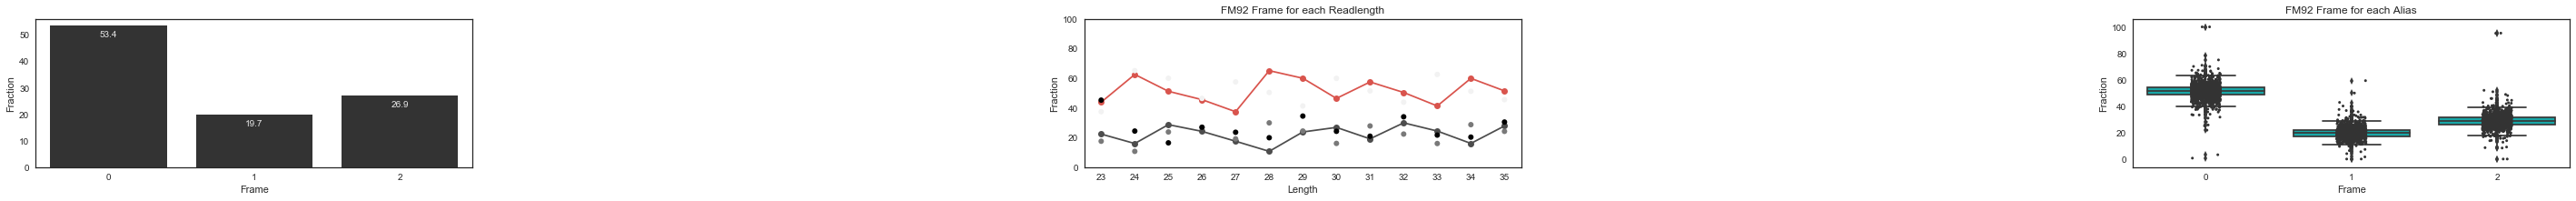

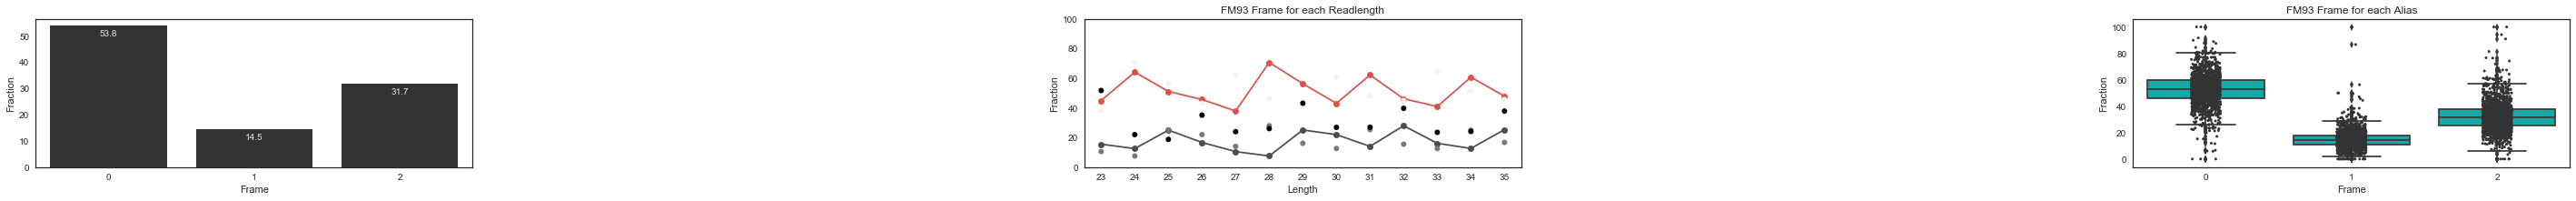

In [6]:
frame_plot = ribo_plot.plot_frame(inputs, paths_in, paths_out, settings, settings_plot)

# Pause Score Analysis

Calculate pause scores for each amino acid, and for each codon. 

   - relative density = (reads at position / average reads of the gene)
   - pause score = avg(relative density over codon or aa) / instances of the codon oraa

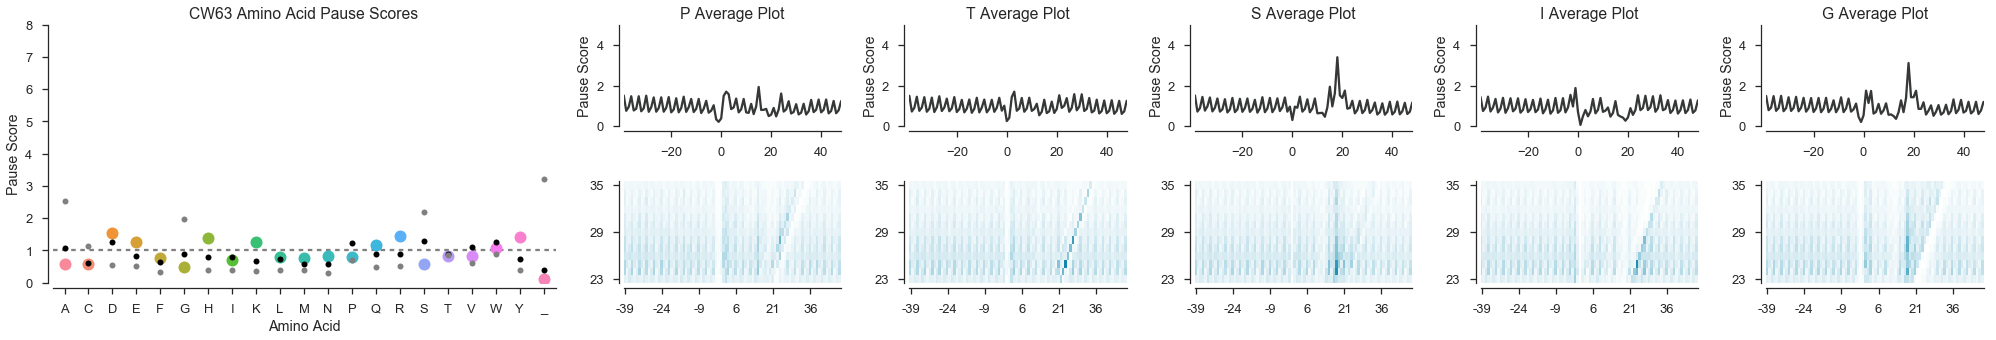

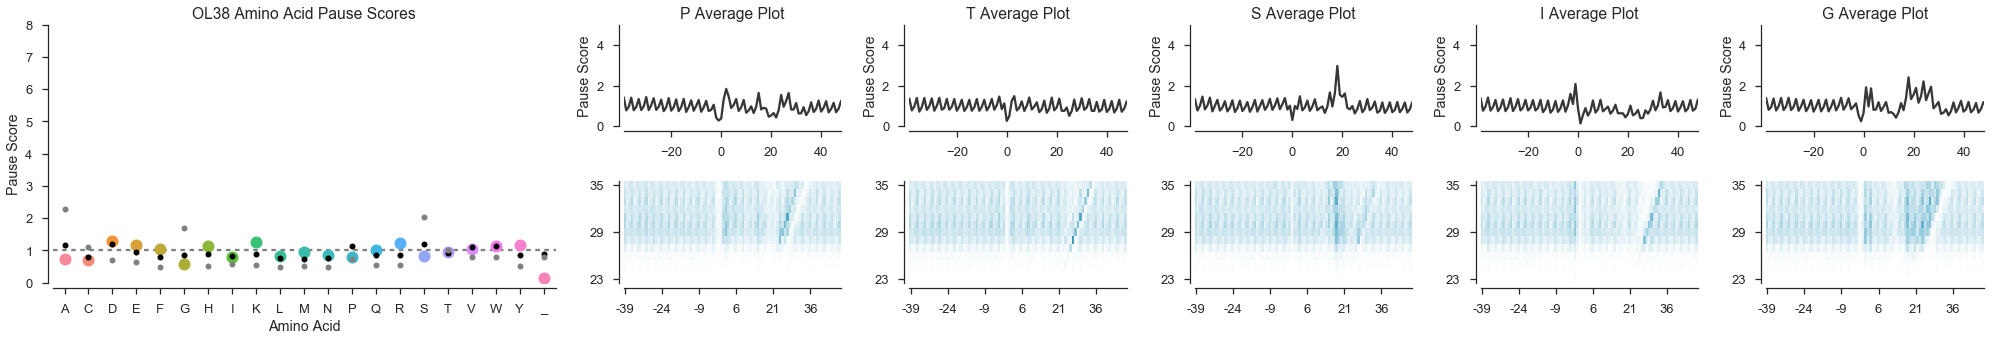

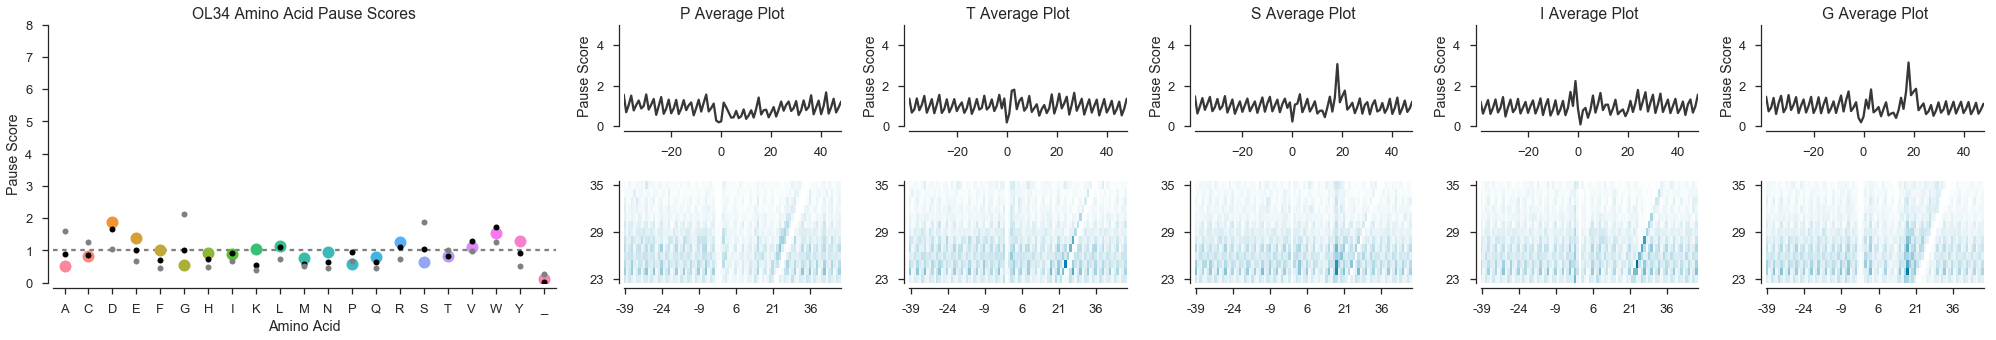

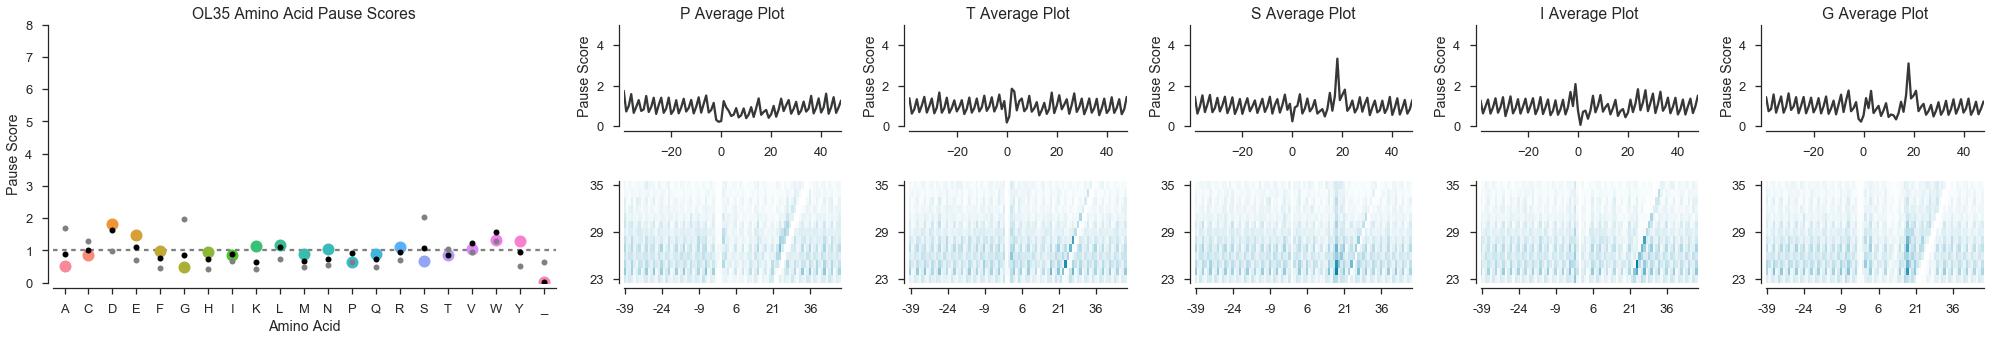

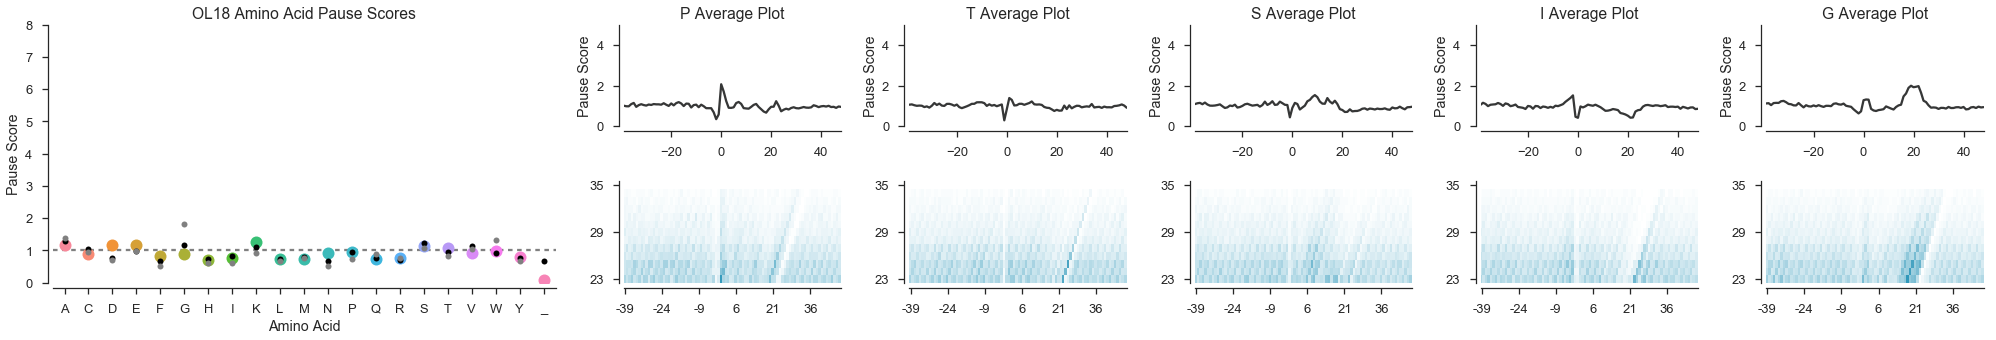

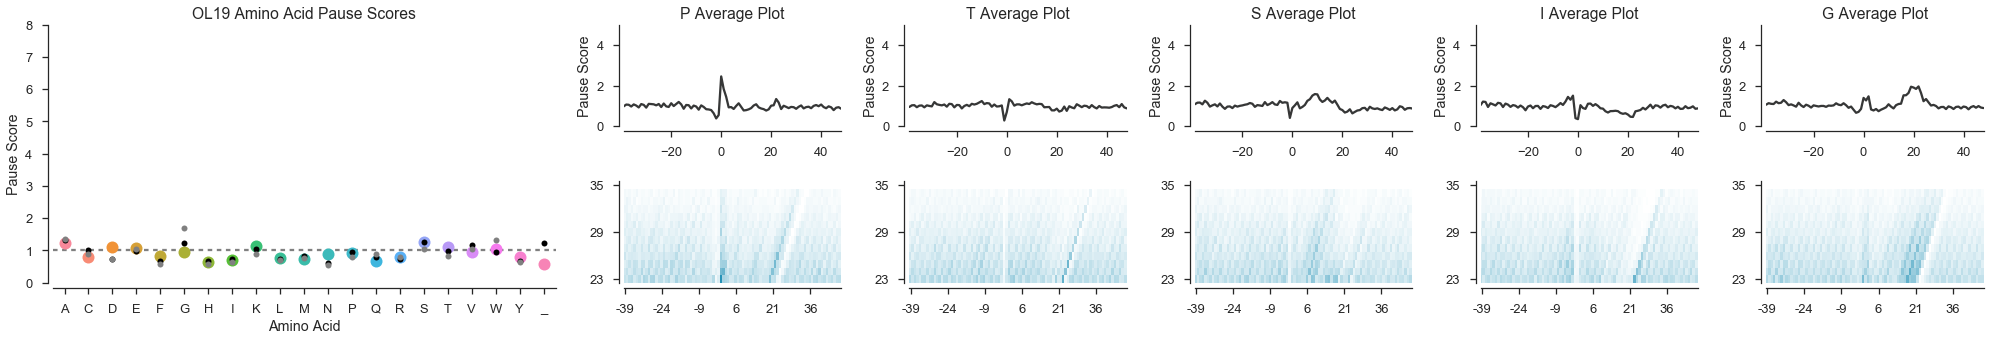

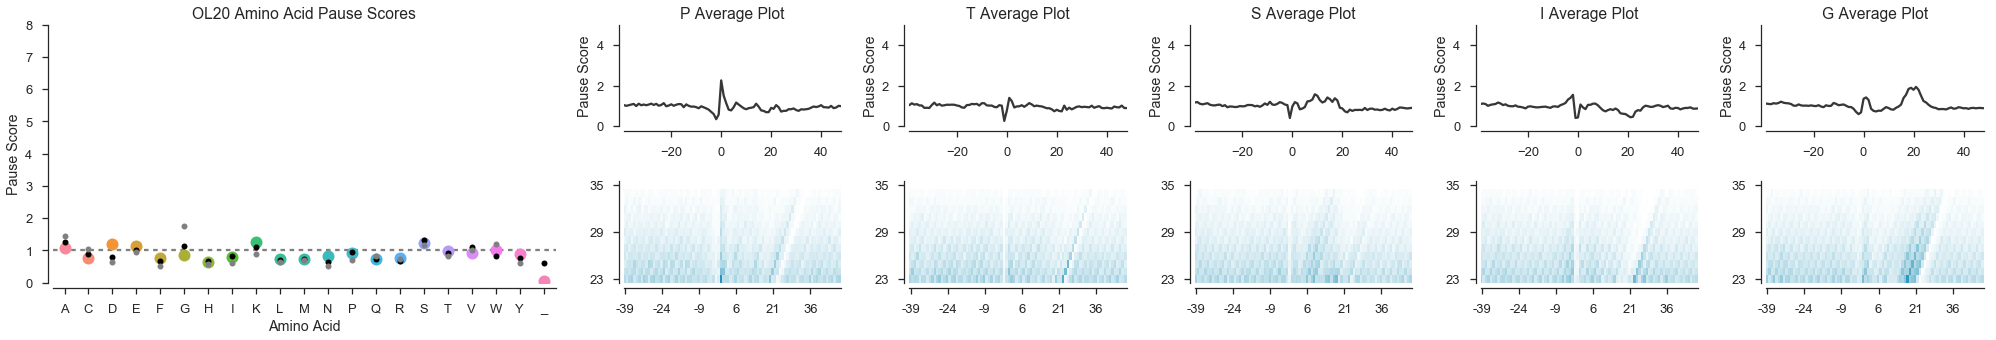

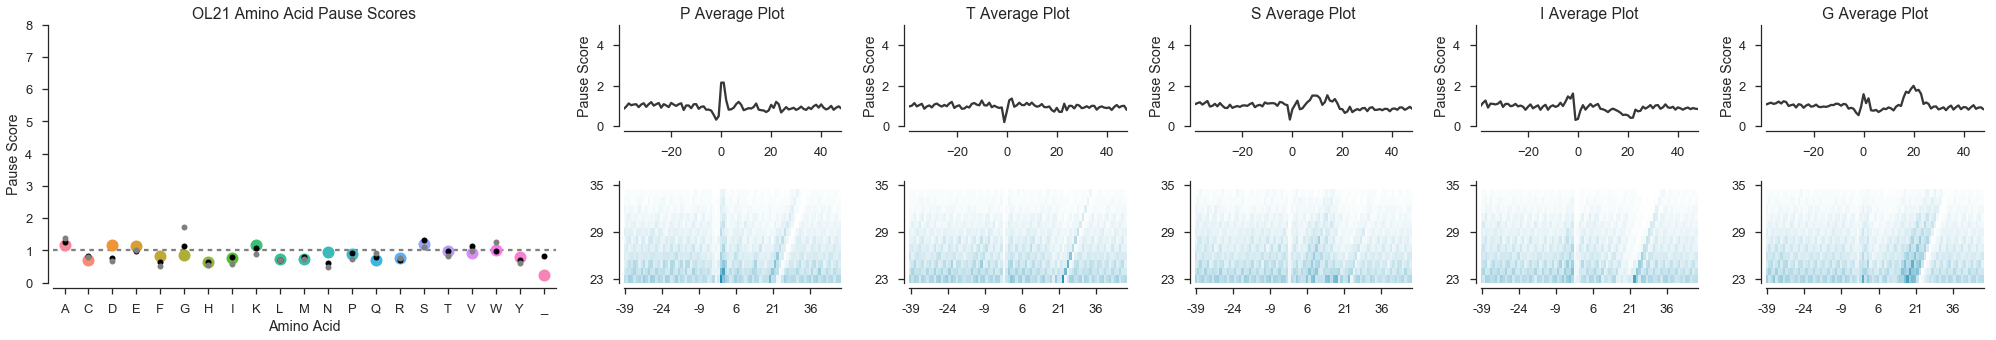

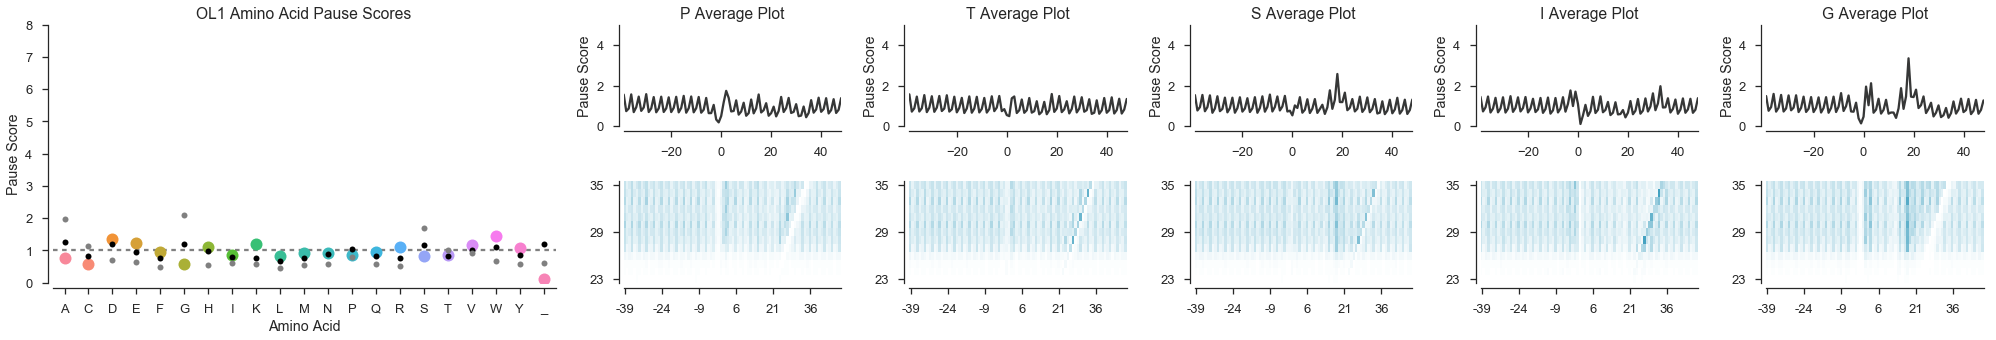

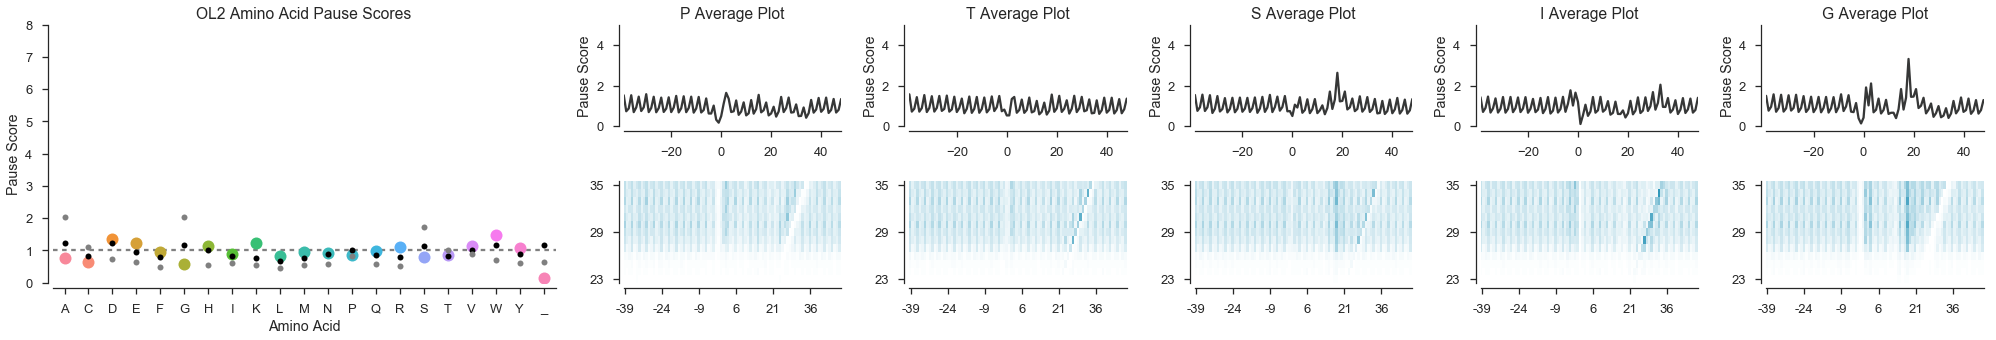

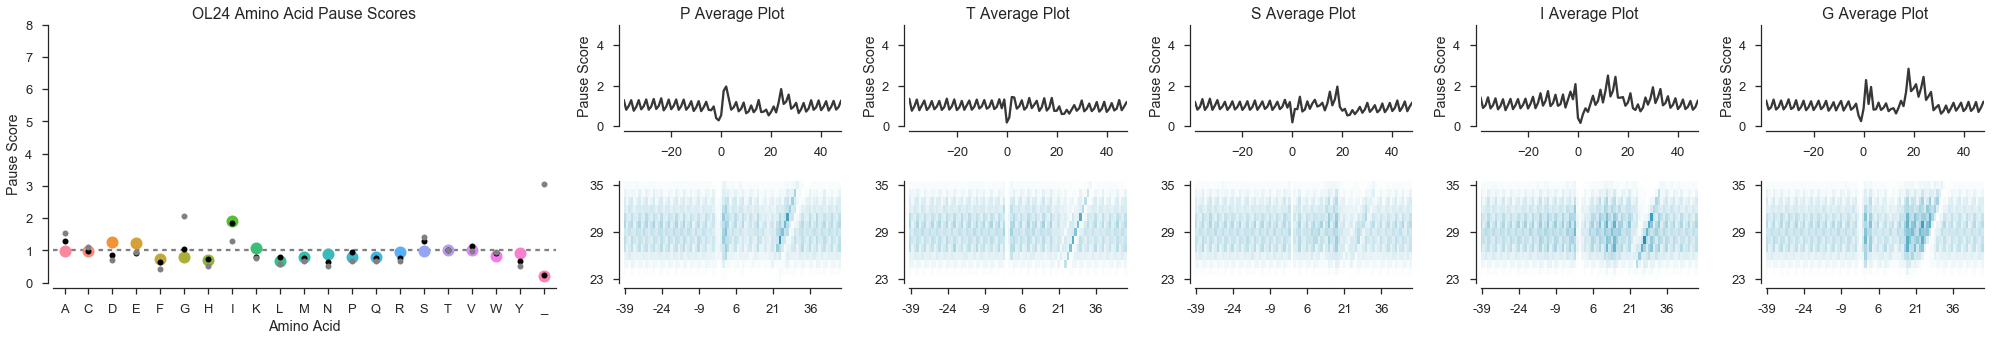

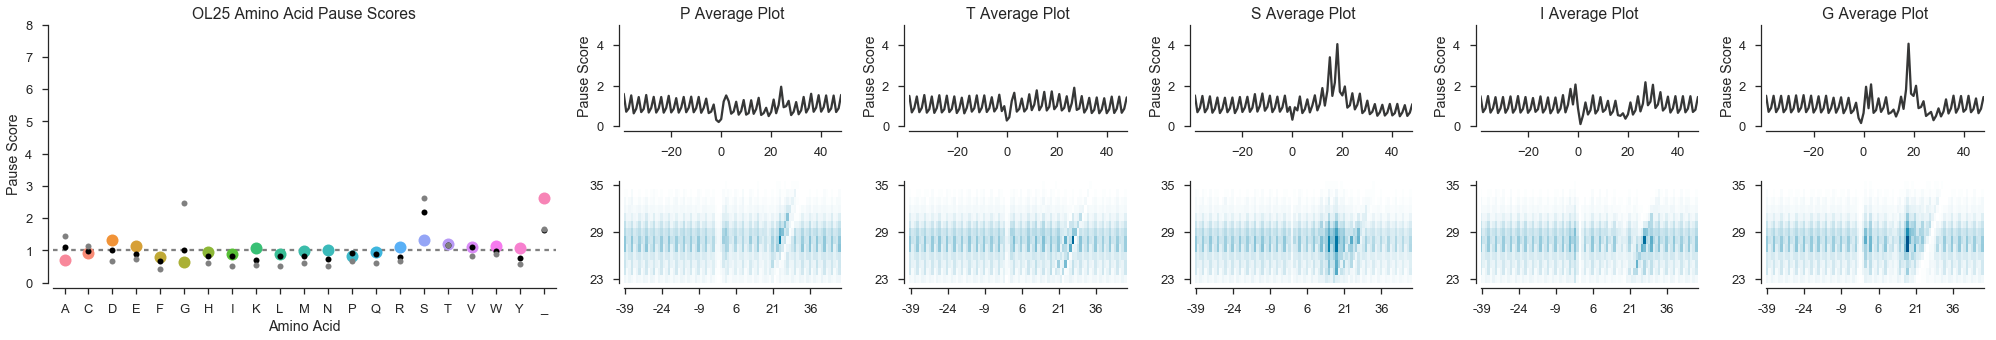

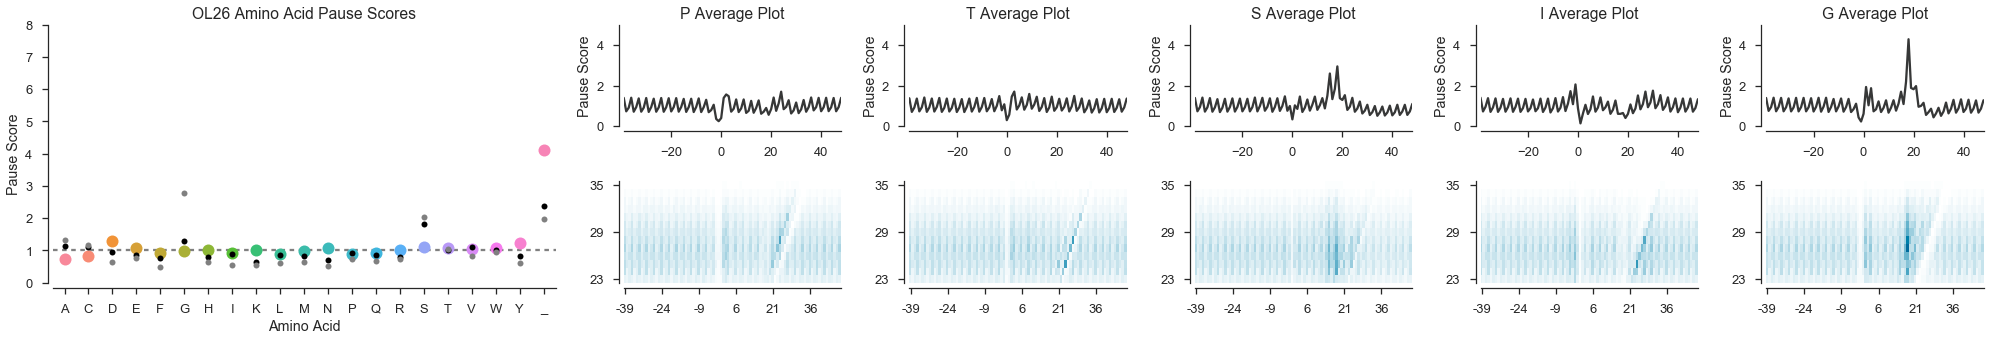

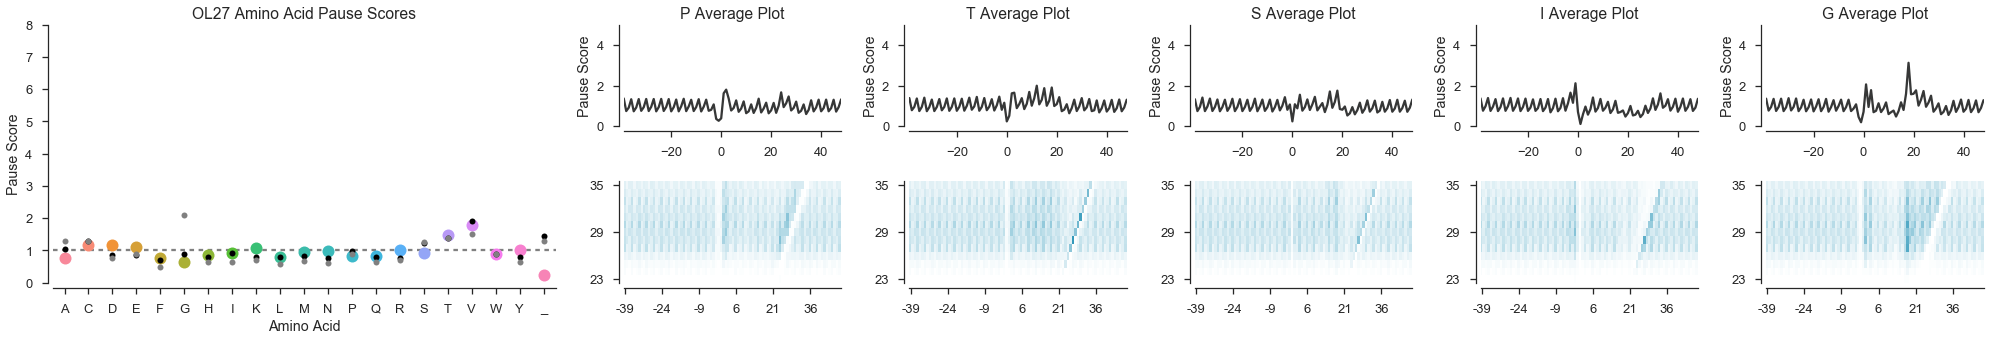

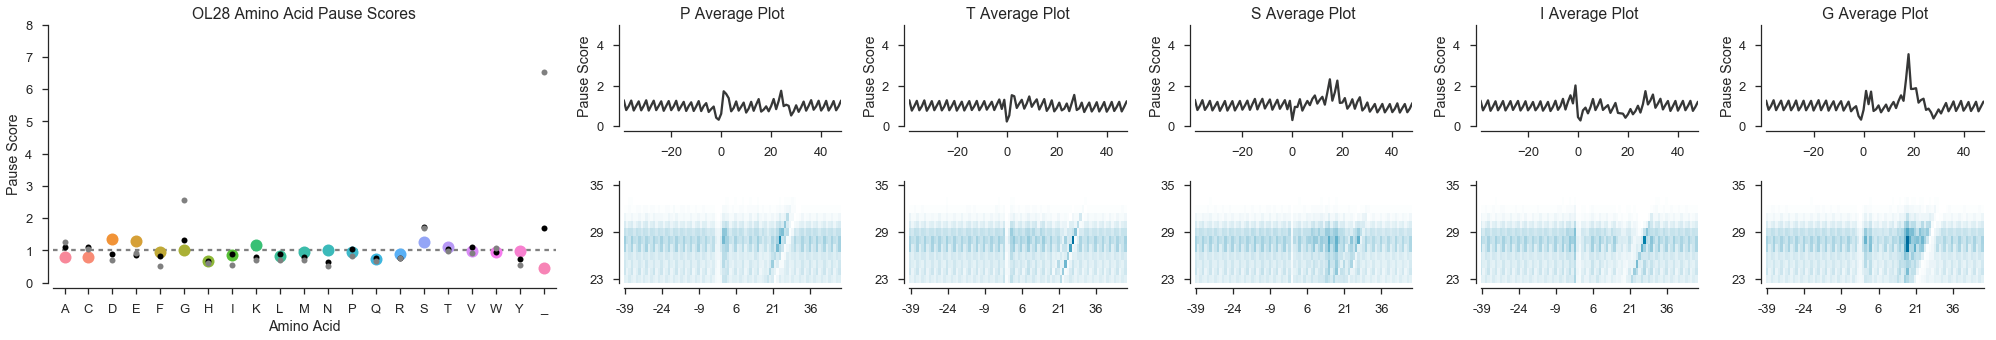

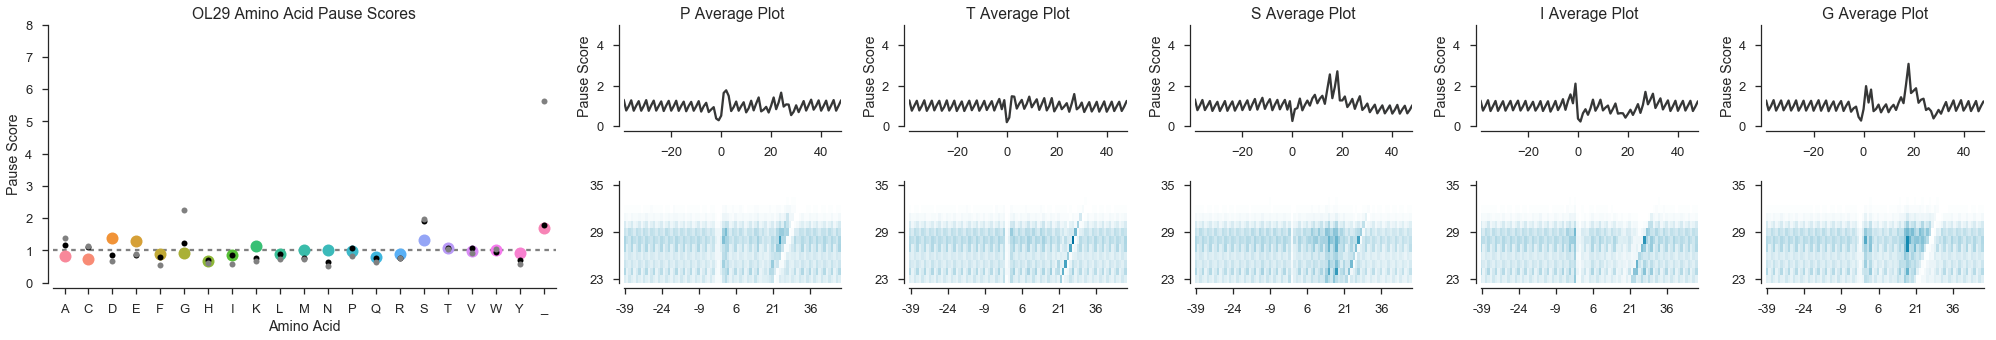

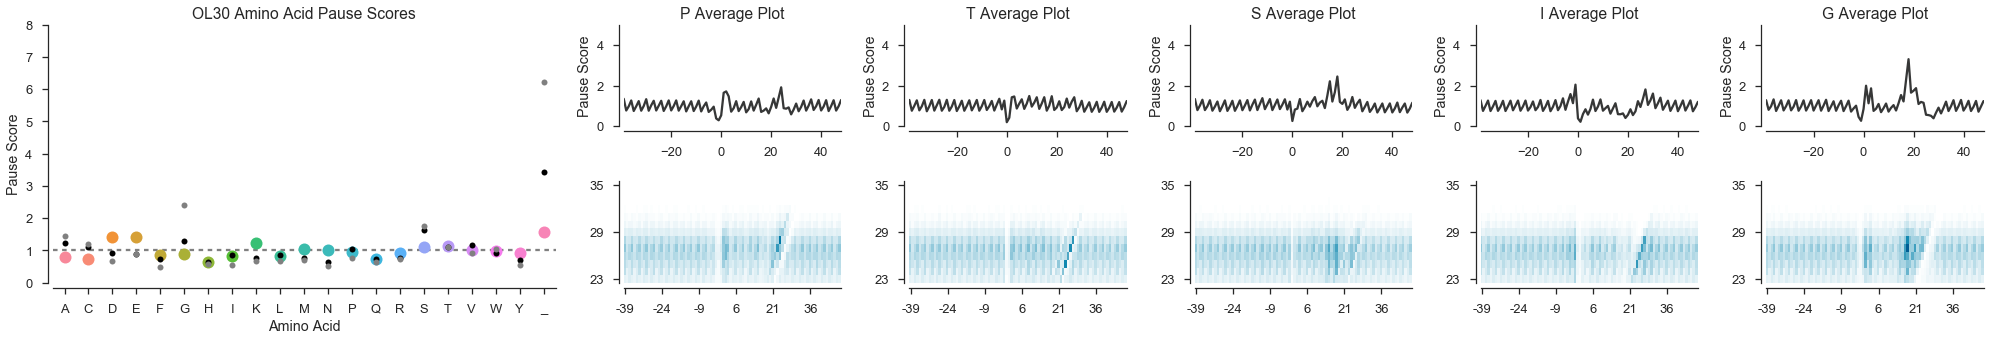

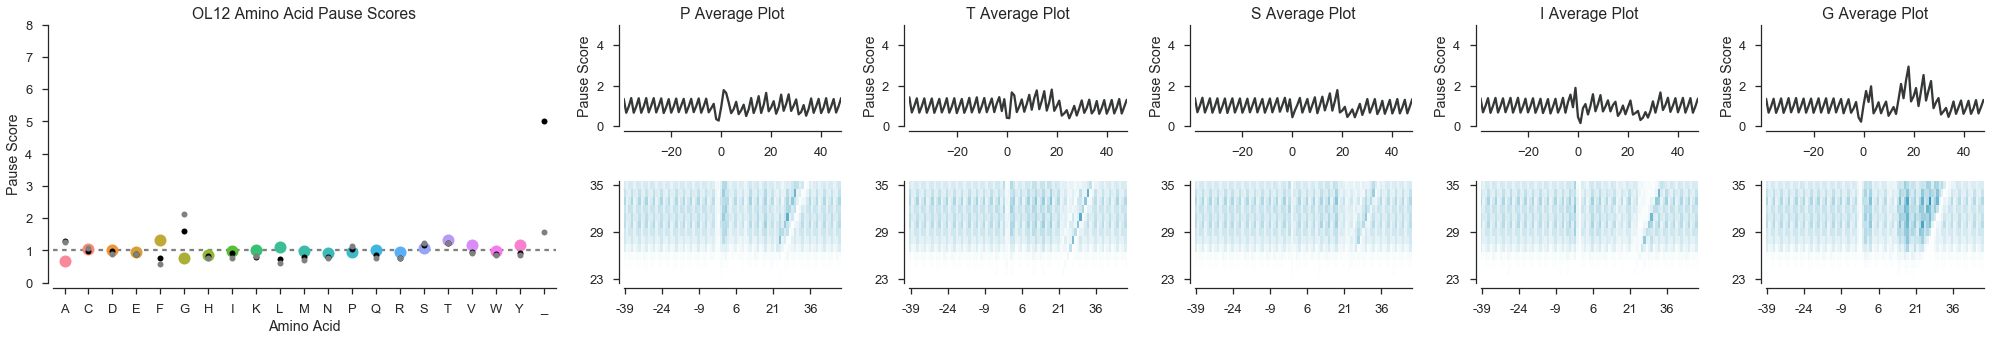

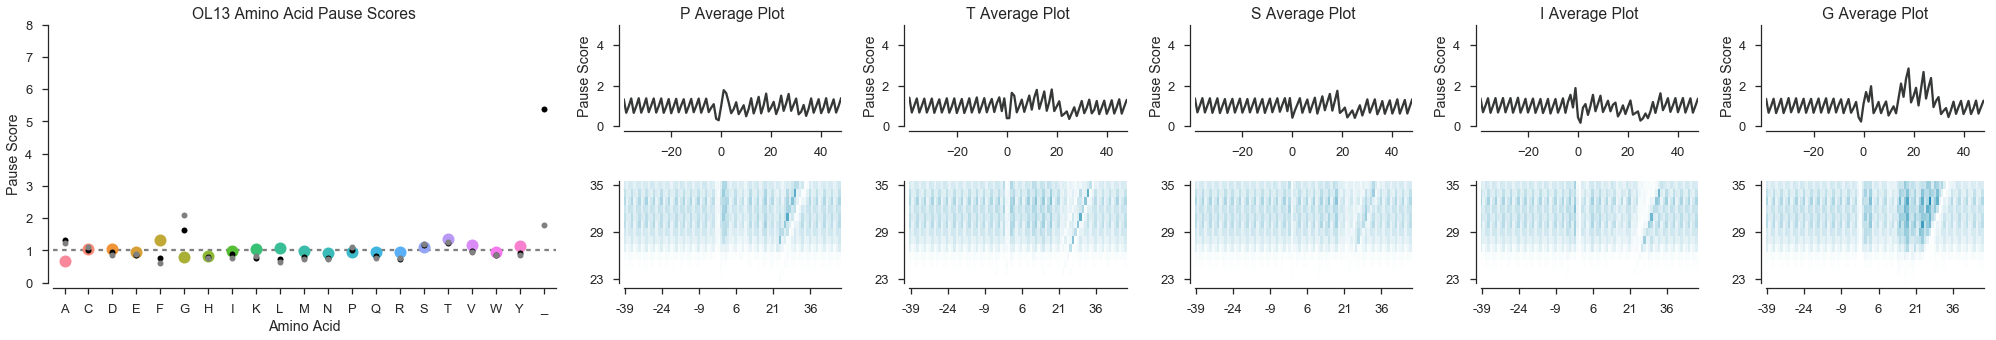

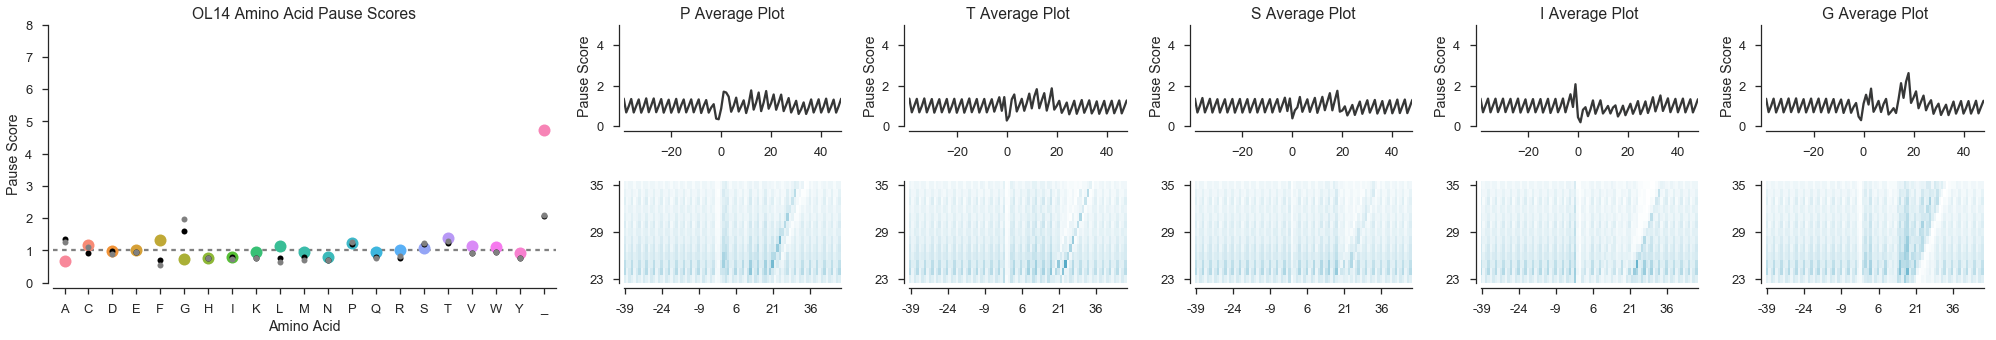

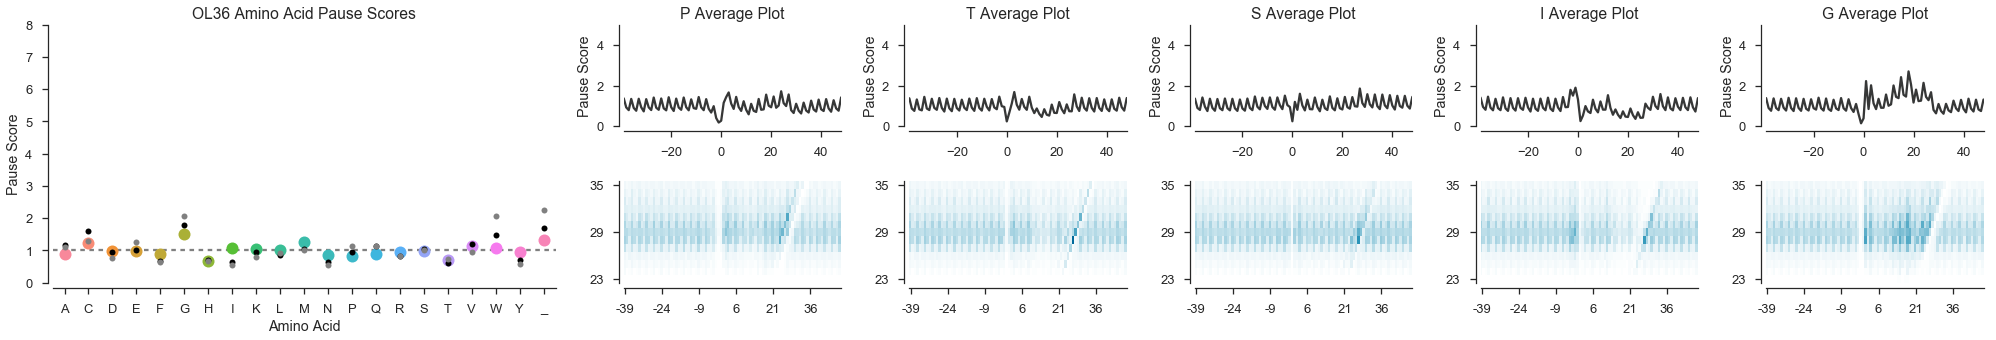

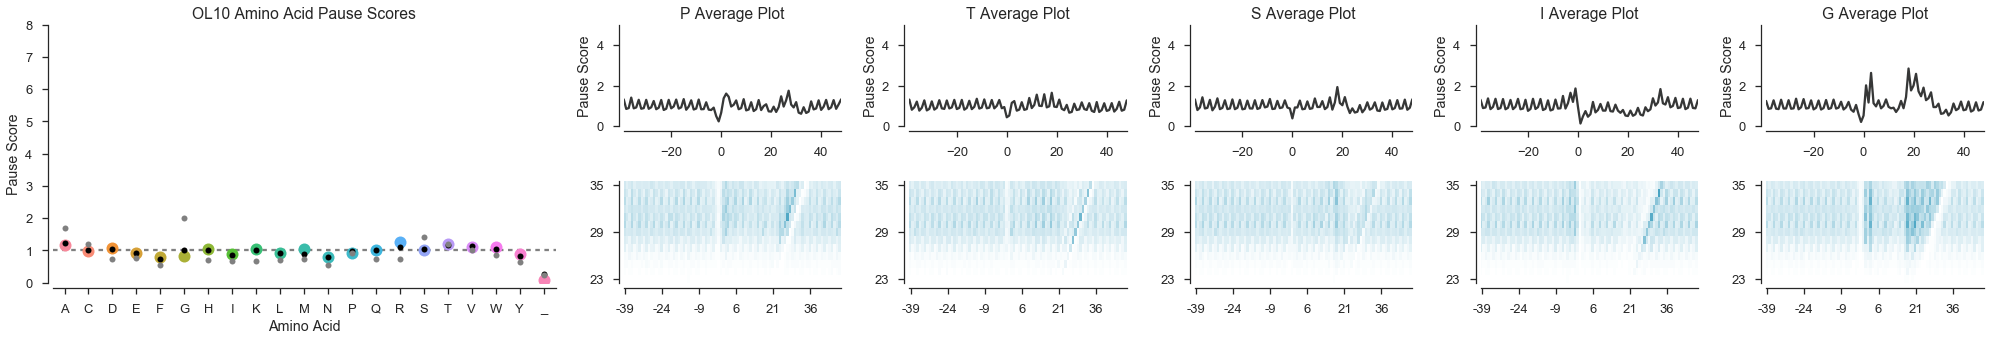

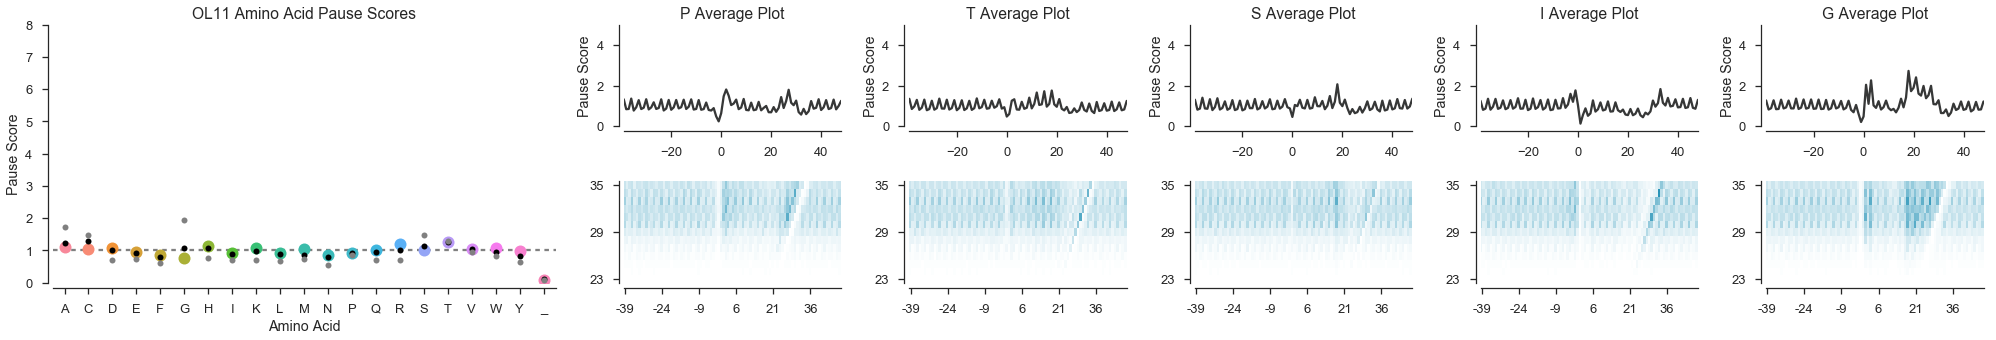

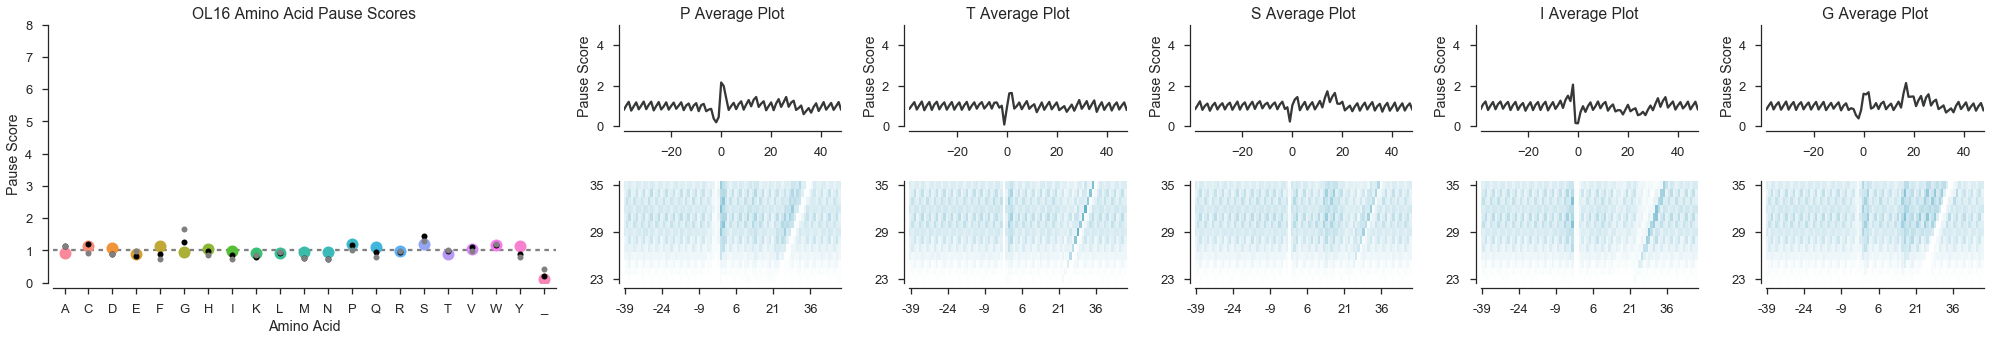

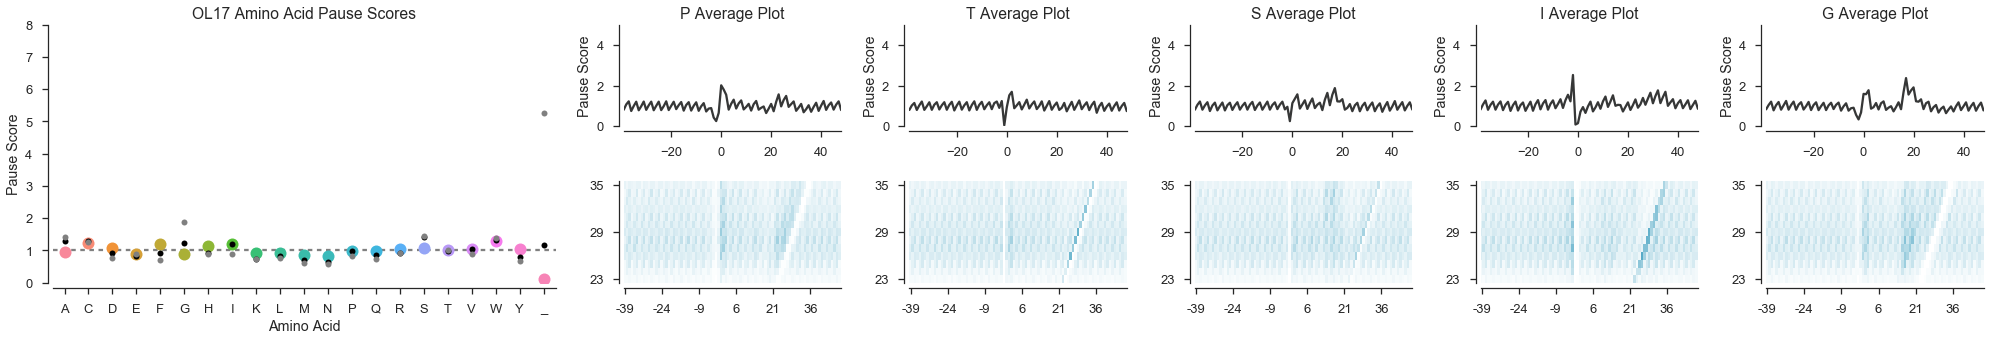

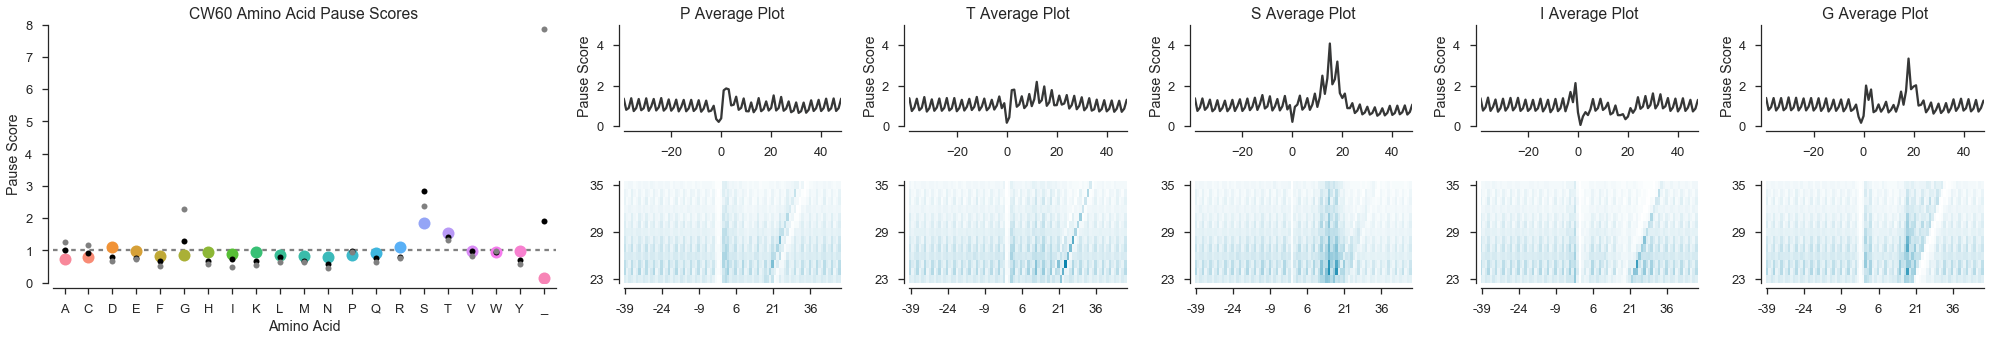

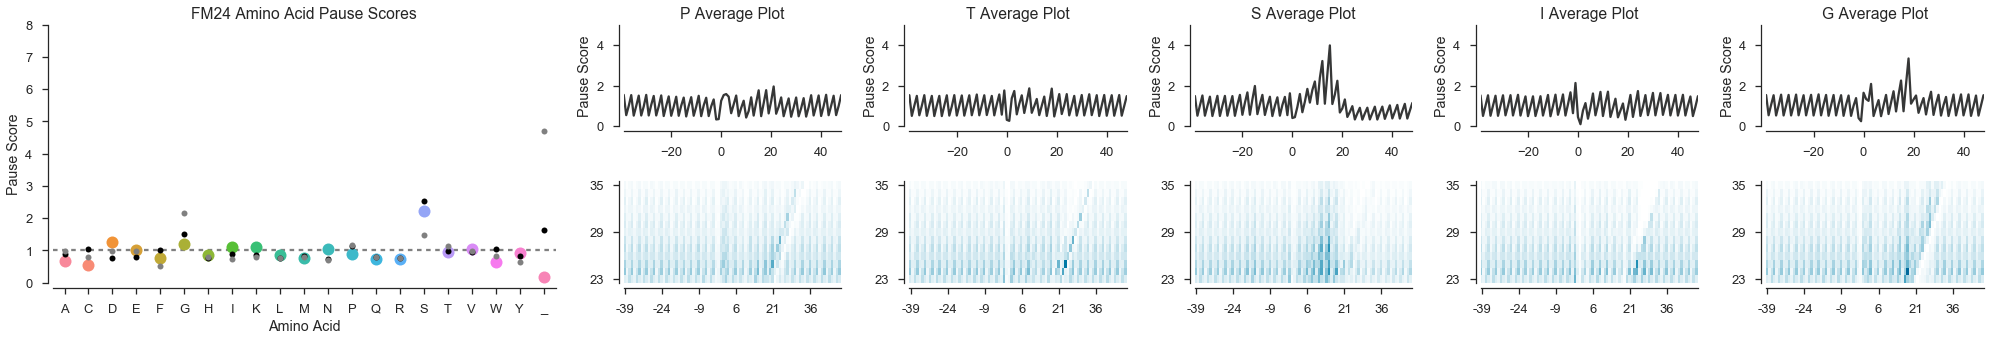

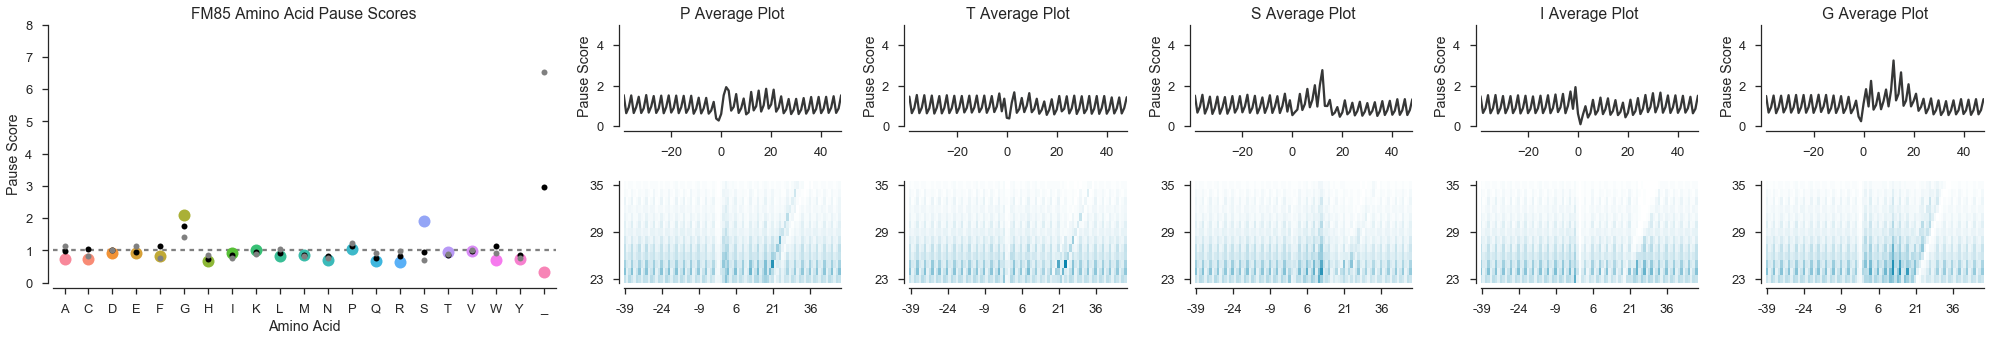

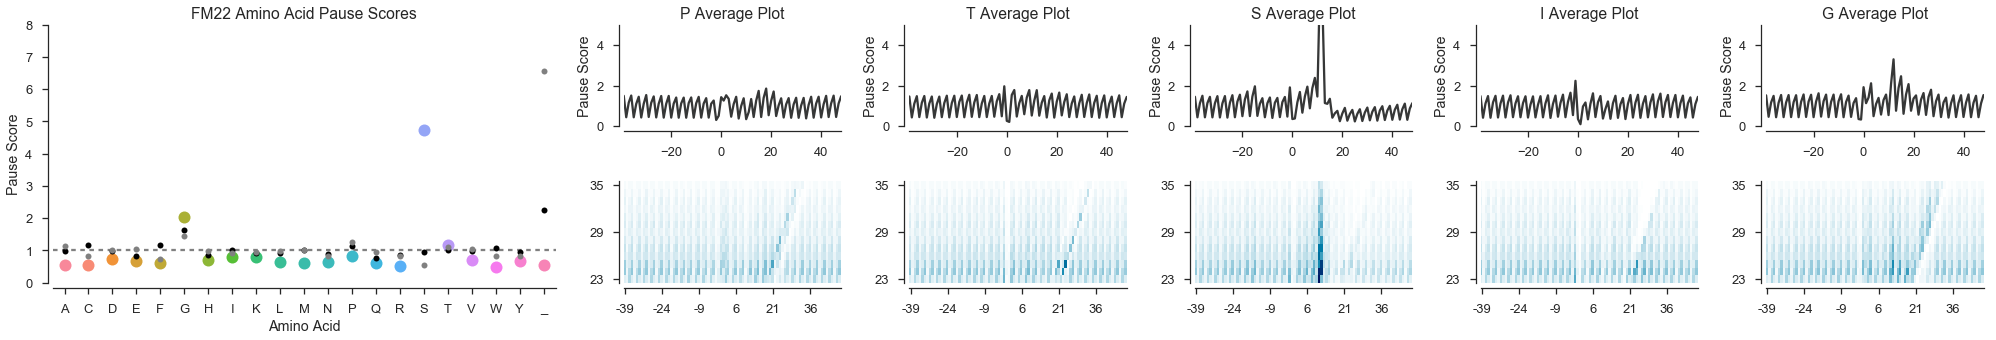

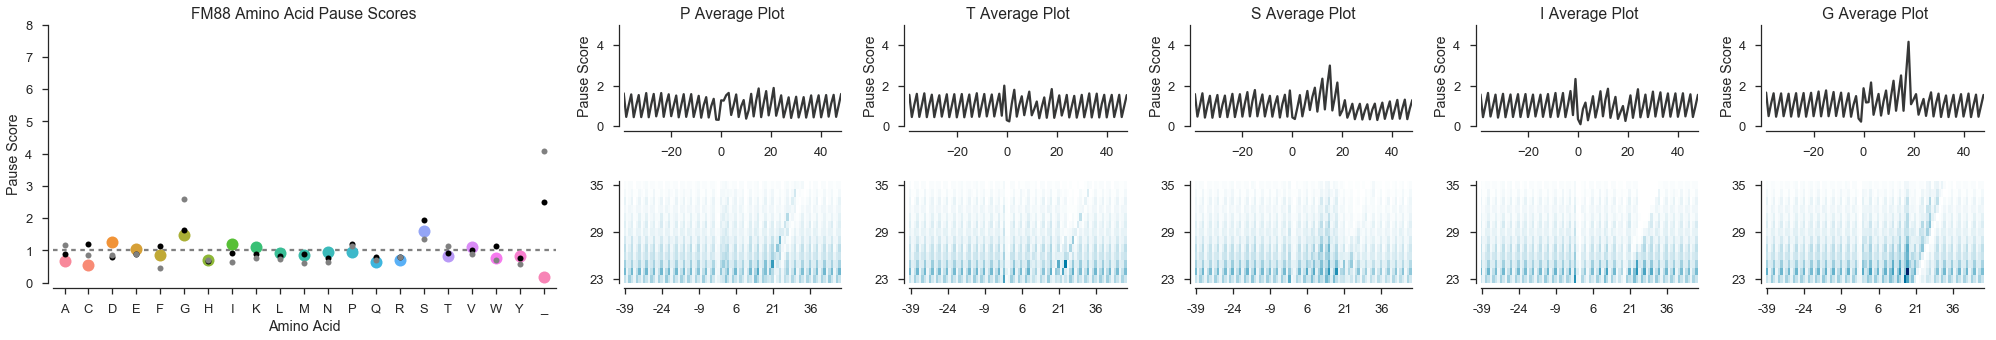

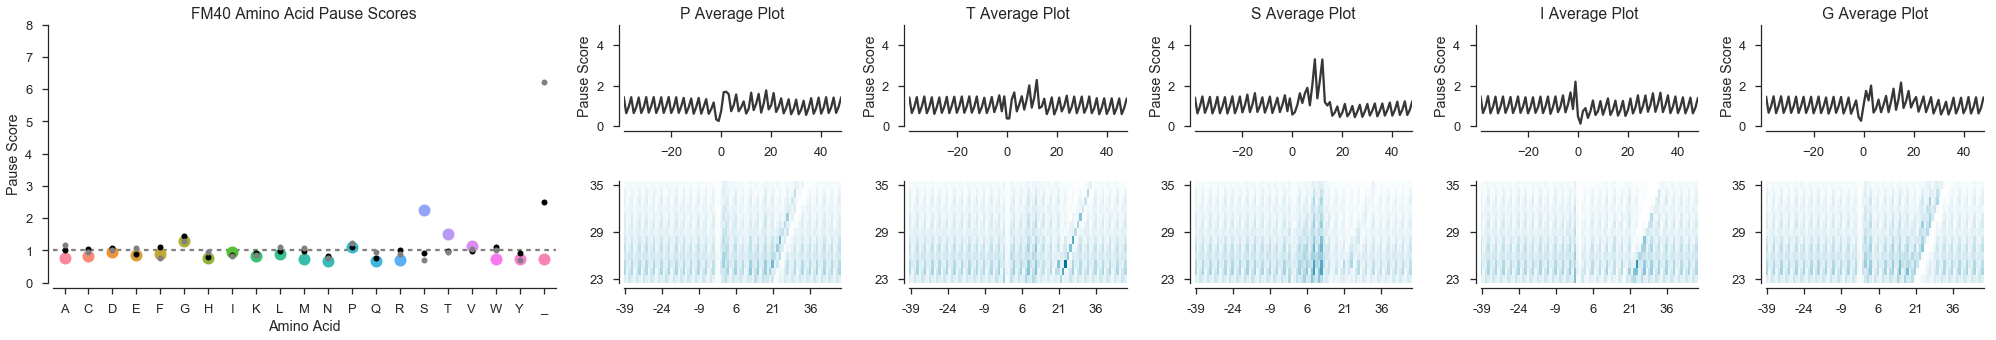

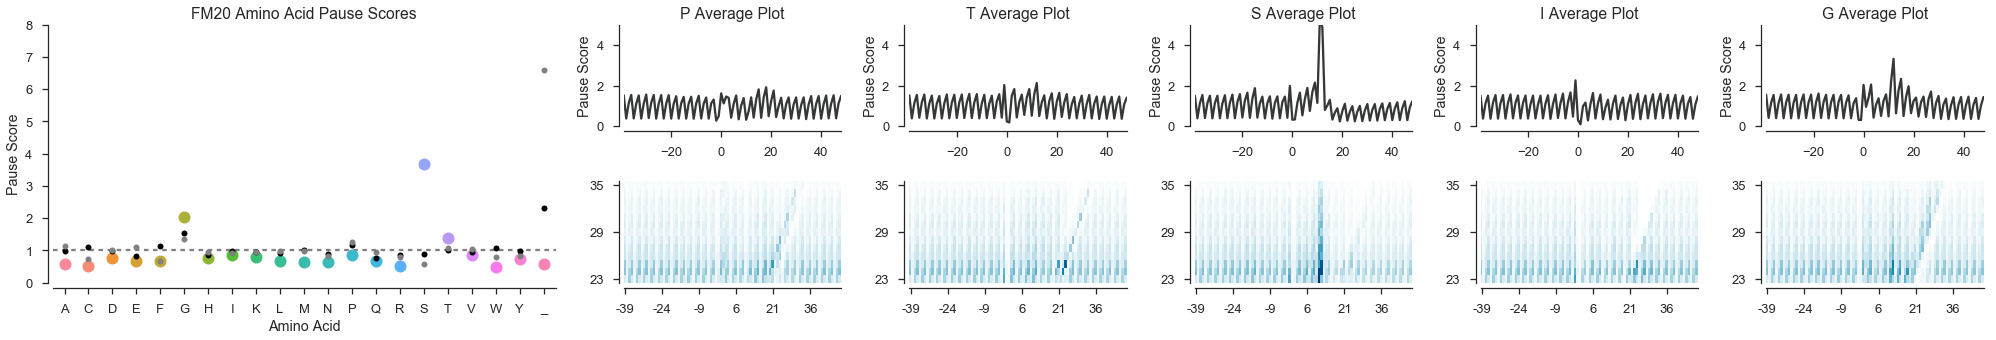

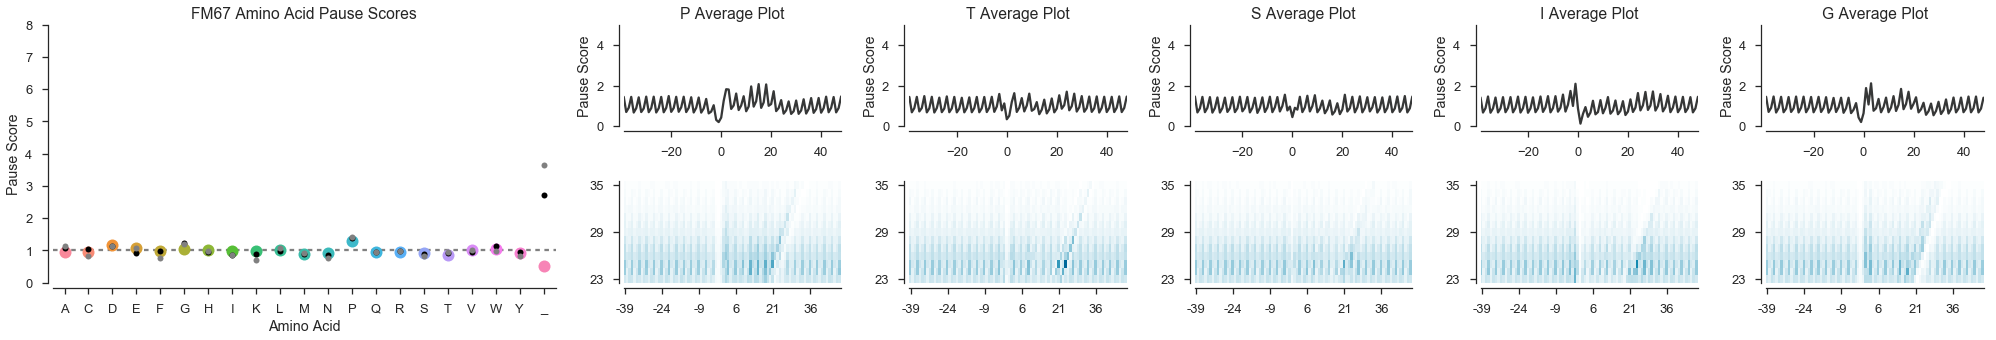

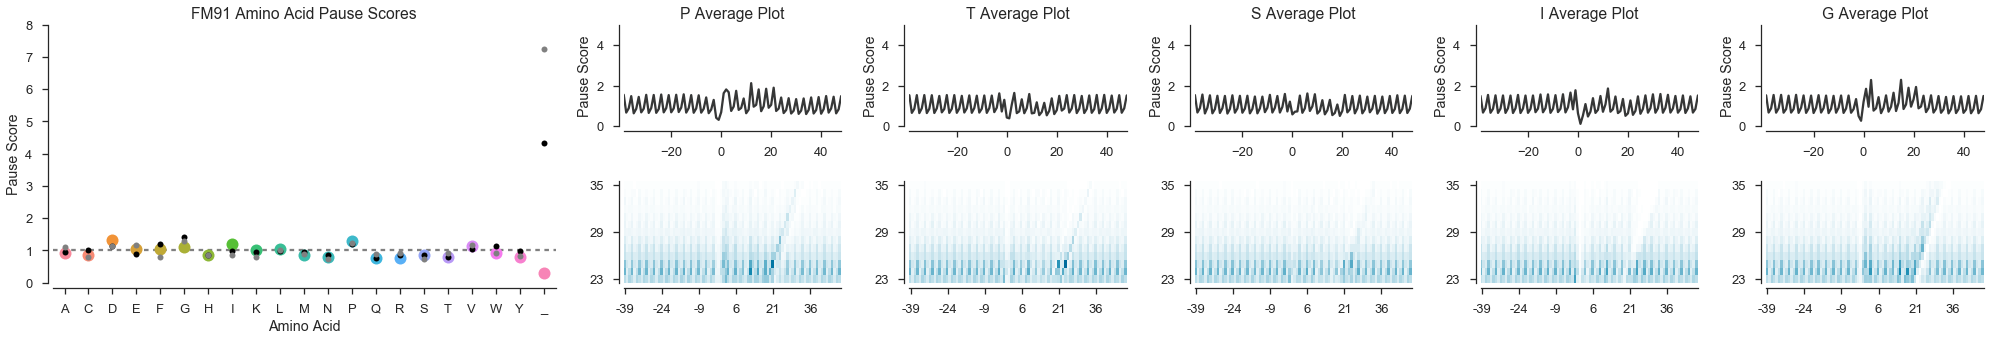

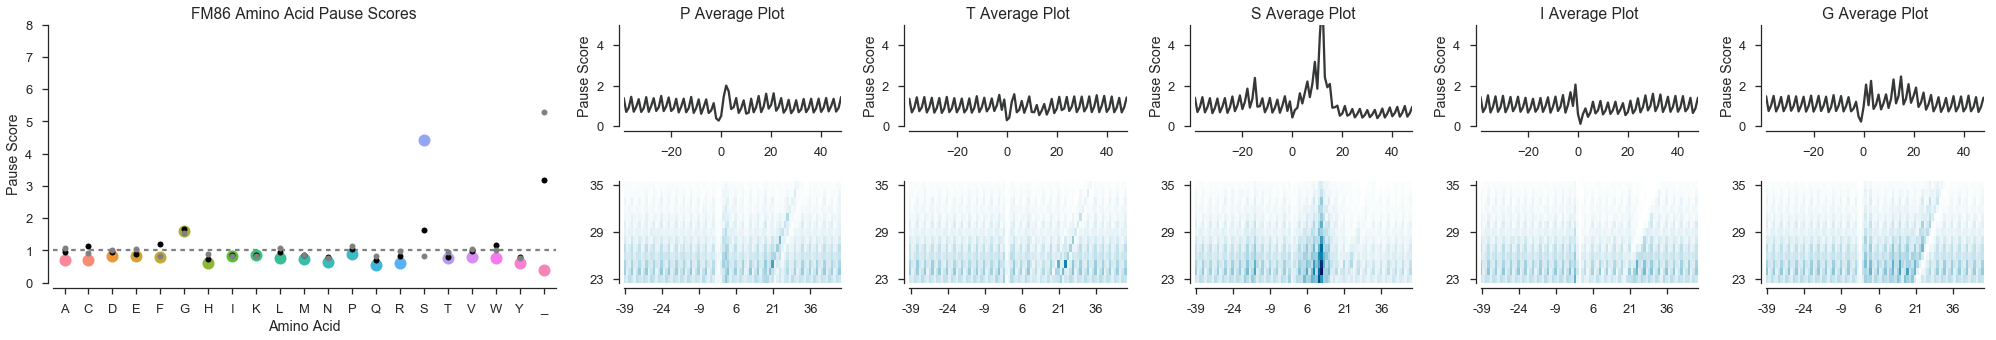

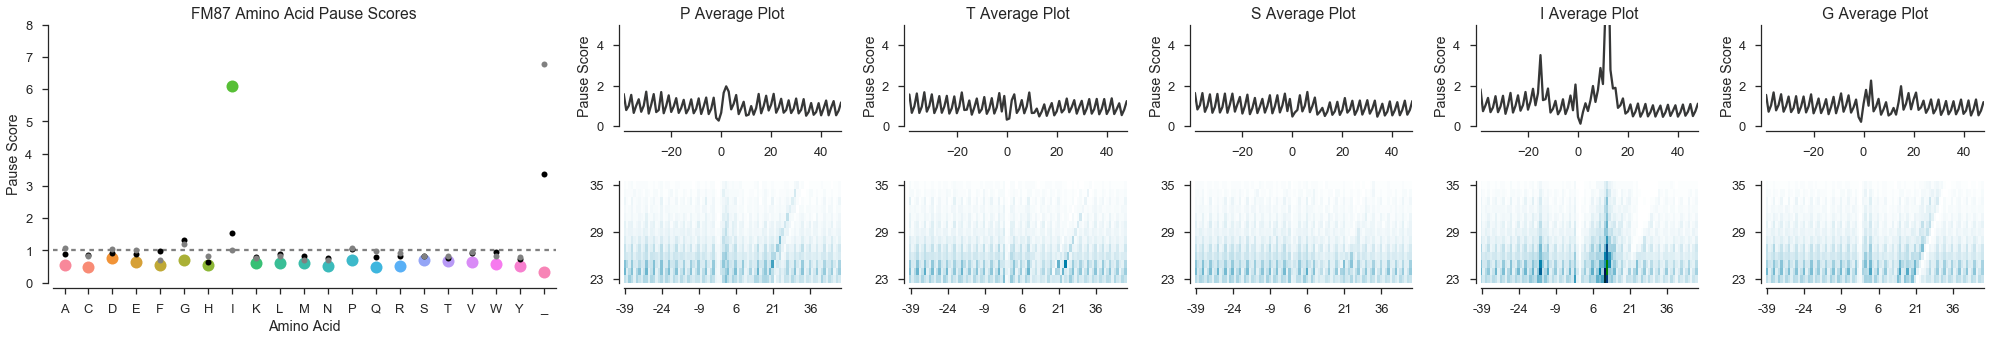

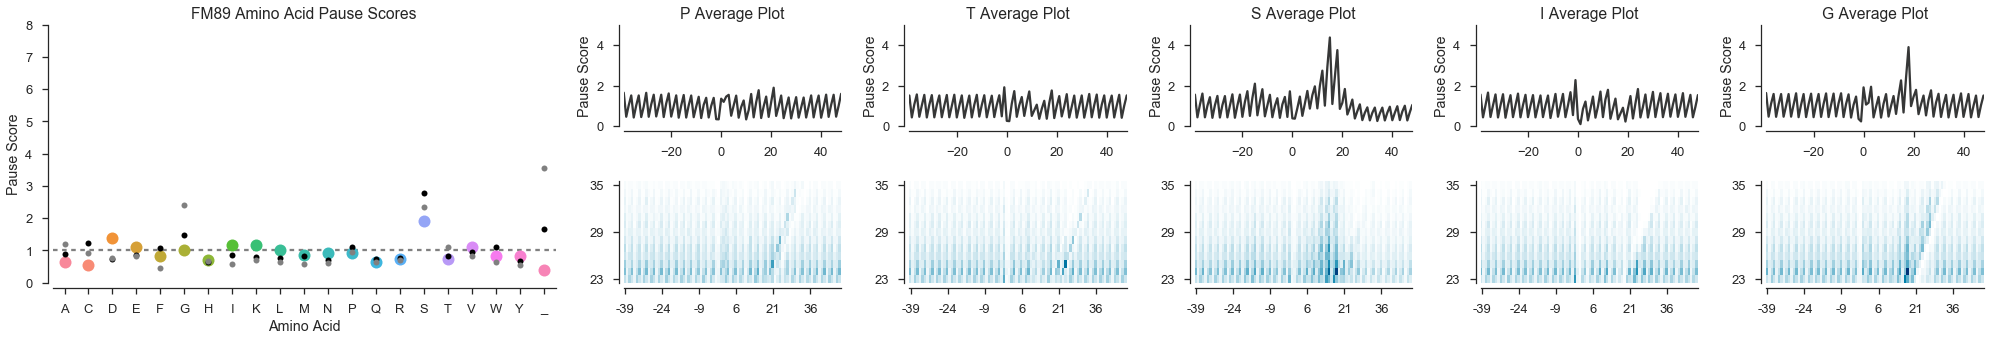

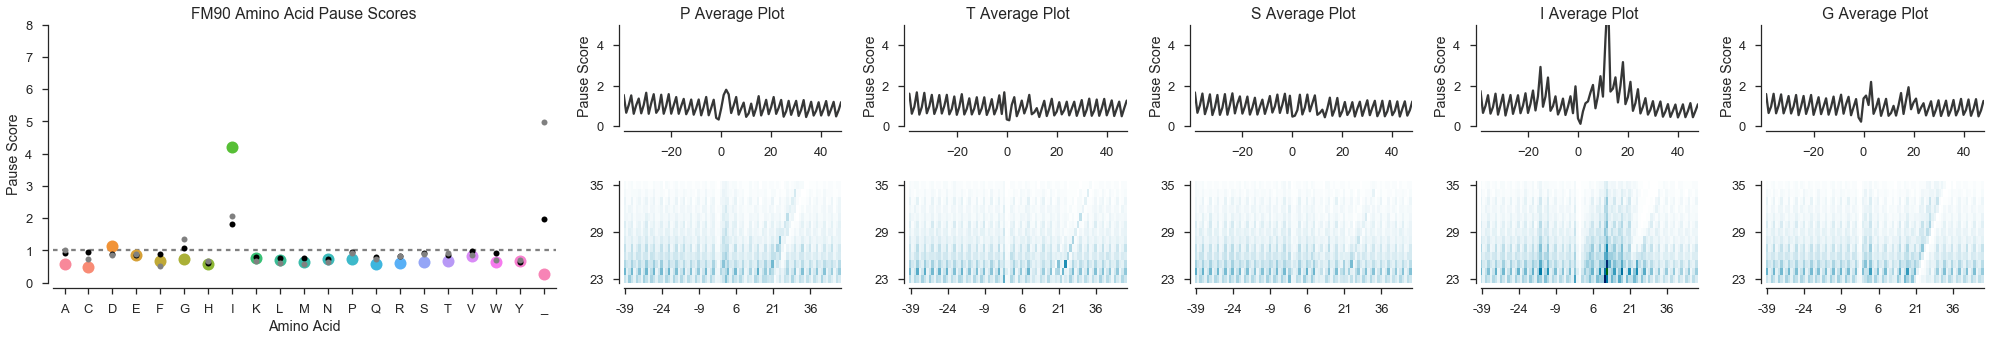

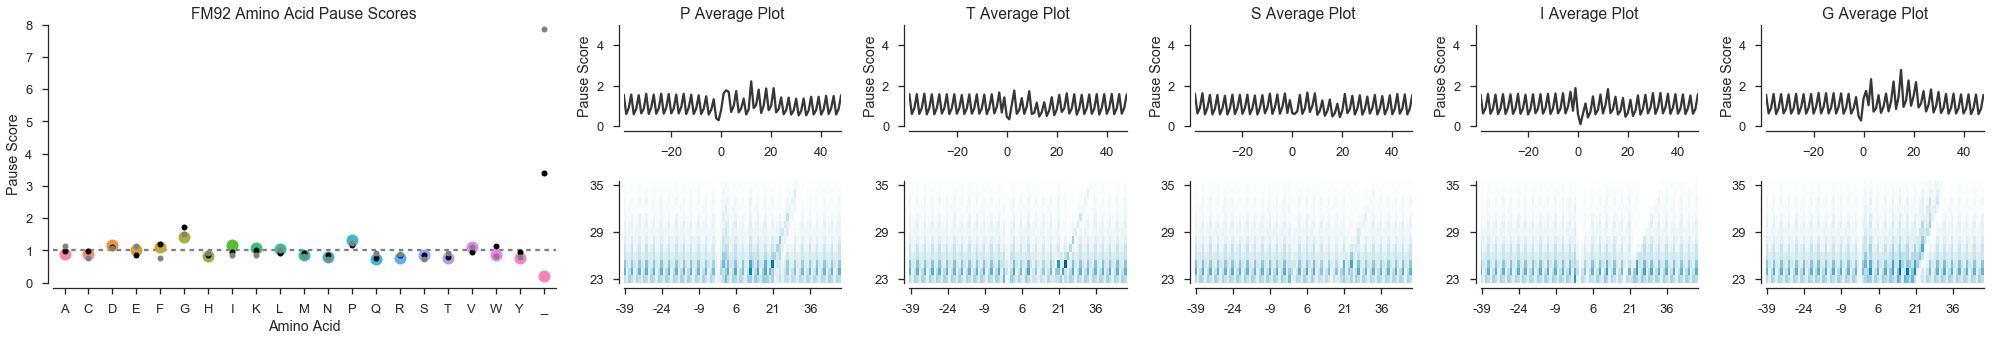

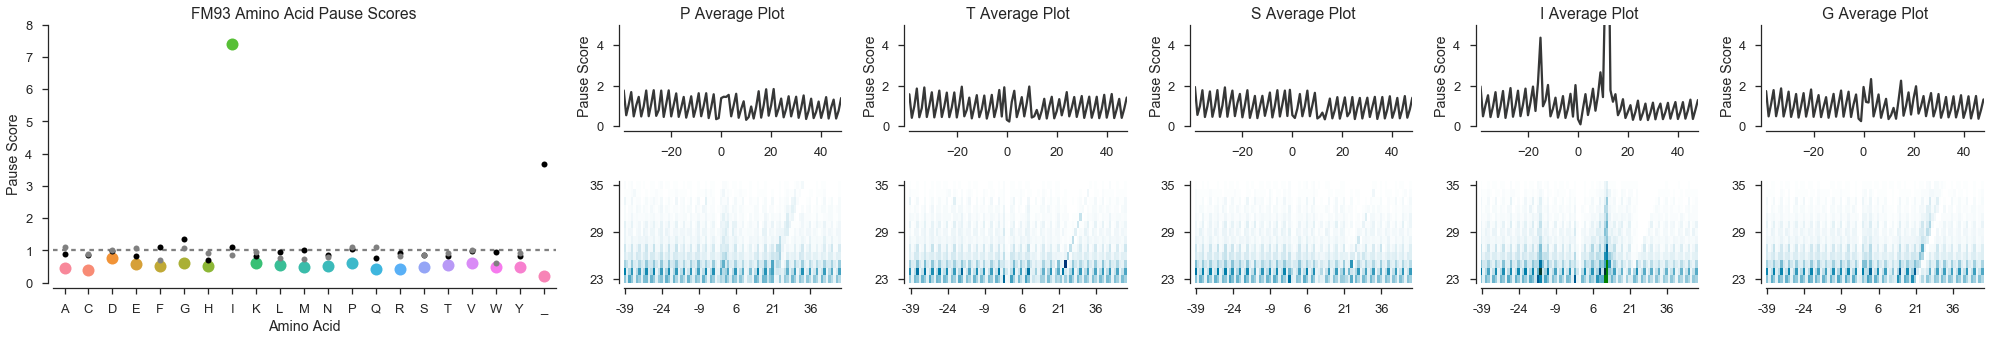

In [7]:
settings_plot['aa_or_codon'] = 'aa' 
settings_plot['amino_acid']  = ['P', 'T', 'S', 'I', 'G']
settings_plot['codon']       = ['ATT', 'ATC', 'CCT', 'CCA', 'CCG', 'ACT']

settings_plot['ymax_dot']  = 8
settings_plot['ymax_line'] = 5
settings_plot['vmax_HM']   = 2

plot_pausescore = ribo_plot.plot_pausescore(inputs, paths_in, paths_out, settings, settings_plot)

# Gene Density

Display density of listed genes

   - RPKM threshold used above still applies. To change, redefine below 

# Compare Pausescores

Analyze pausescores using heatmaps:

In [34]:
paths_in['files']          = path_pc  + 'Methods_paper/all_libraries.csv'
settings_plot['center_HM'] = 1
settings_plot['vmax_HM']   = 2

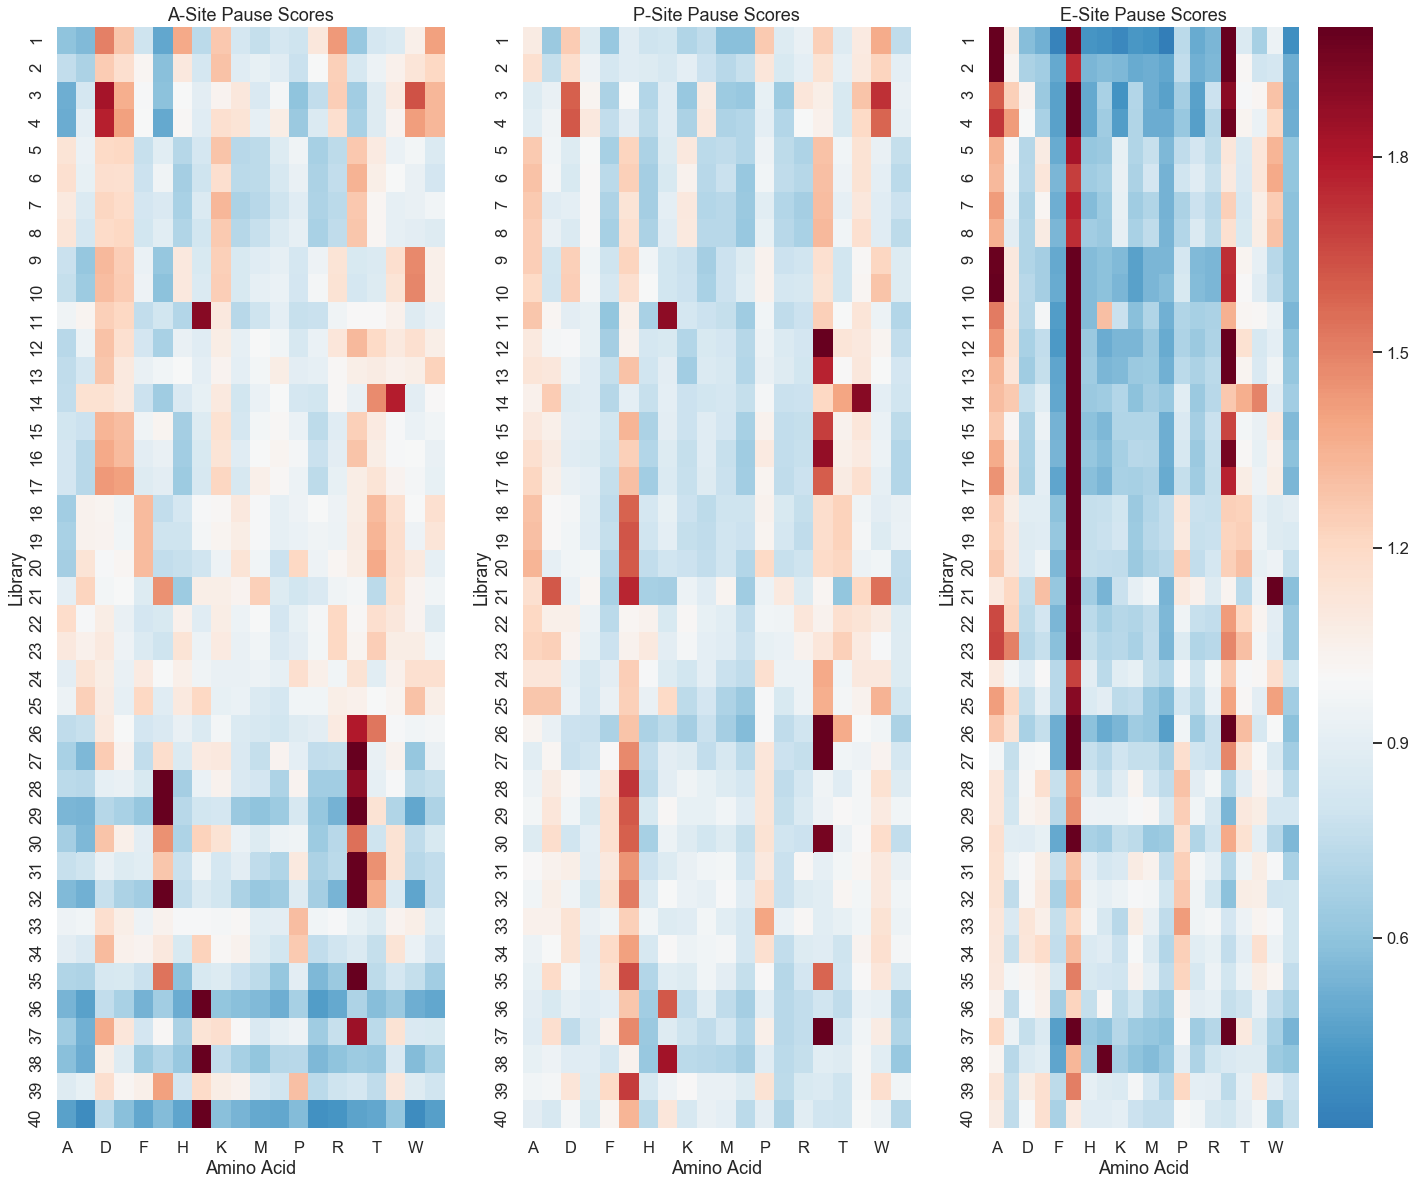

In [35]:
Pause_heatmap = ribo_plot.plot_pausescore_APE_heatmap(inputs, paths_in, paths_out, settings, settings_plot)

# Serine Wave Plots

Plot ribosome occupancy downstream of serine pauses

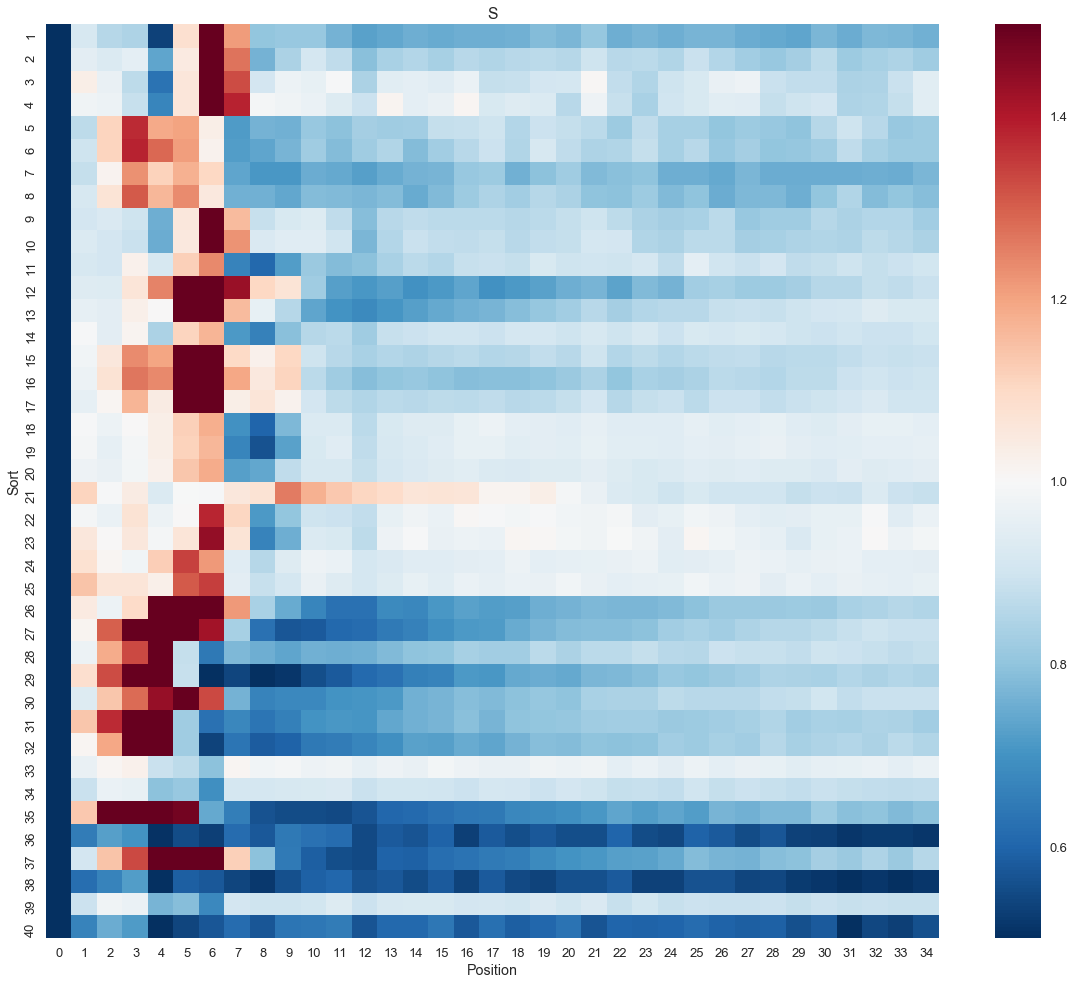

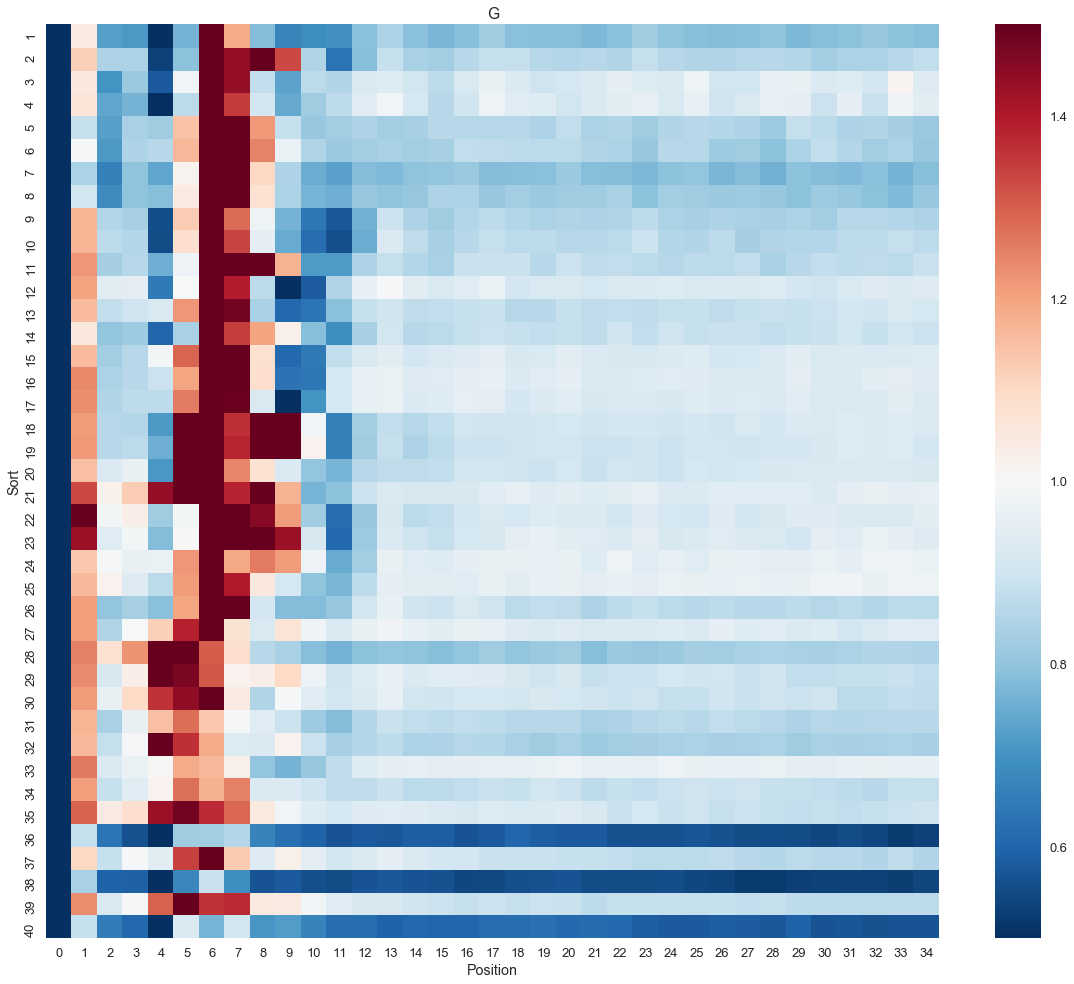

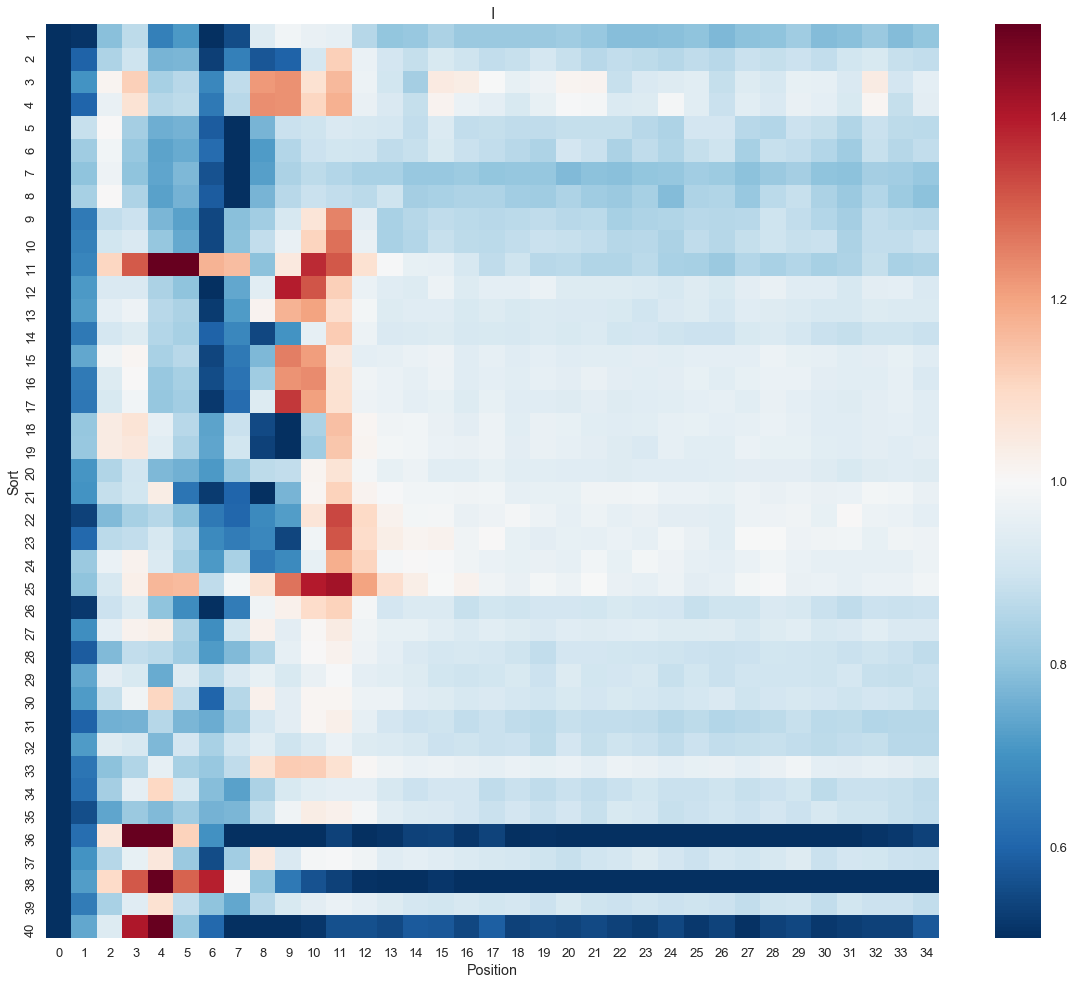

In [10]:
paths_in['files']          = path_pc  + 'Methods_paper/all_libraries.csv'
settings_plot['amino_acid']  = ['S', 'G', 'I']
settings_plot['center_HM']   = 1
settings_plot['vmax_HM']     = 1.5


Pause_wave = ribo_plot.plot_pausescore_downstream(inputs, paths_in, paths_out, settings, settings_plot)

# Asymmetry Plot

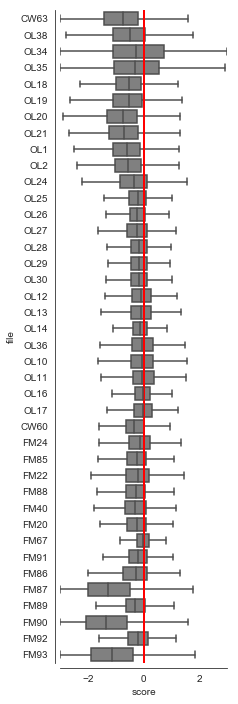

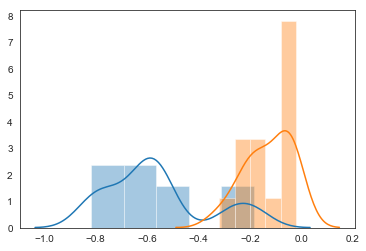

Ttest_indResult(statistic=-7.3750049140105496, pvalue=1.6819274219263927e-07)
number of genes in treated = 10
number of genes in untreated = 15

treated =  [-0.8181077055603555, -0.53801811308356473, -0.18408105459142104, -0.26851827026942232, -0.55837647602280205, -0.58446330837989247, -0.78486401783180793, -0.71009358554816848, -0.63027021025070606, -0.58613342045717576]

untreated =  [-0.3191744132362157, -0.20319109559189408, -0.21888537396092889, -0.24287492223775339, -0.15697049277326616, -0.15688129491650432, -0.17436938456087295, -0.056992392594754075, -0.073548703694299986, -0.11664693355465379, -0.035987724409339956, -0.048107448069843149, -0.020508150797786426, -0.038926089115583193, -0.042948521851543187]


In [30]:
inputs['files'] = all_files
asymmetry = ribo_plot.plot_asymmetry_comp(inputs, paths_in, paths_out, settings)